<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [176]:
%pip install statstests

In [177]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [178]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [180]:
df.head()

,date_window,frauds,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_health_medical,category_sports_recreation,category_travel_hospitality,category_retail_clothing_accessories,category_professional_business_services,category_financial_insurance,category_retail_specialty,category_retail_home_garden,category_construction_contractors,category_personal_services
0,2010-01-01 00:00:00,0,46.696554,54.628788,15.136733,58221.810606,716.227273,66.160064,3.946970,1.494593,...,0.03,0.02,0.01,0.02,0.01,0.07,0.04,0.00,0.0,0.0
1,2010-01-01 06:00:00,0,59.582605,55.579336,15.037152,56695.811808,716.075031,65.384731,3.979090,1.554686,...,0.04,0.01,0.00,0.00,0.00,0.05,0.02,0.01,0.0,0.0
2,2010-01-01 12:00:00,0,82.216067,56.356397,16.281097,54322.728460,716.154047,63.952840,3.881201,1.566892,...,0.03,0.01,0.01,0.01,0.00,0.05,0.01,0.01,0.0,0.0
3,2010-01-01 18:00:00,1,61.784377,55.416667,14.765719,53964.464583,708.252083,68.100449,3.831250,1.542259,...,0.02,0.02,0.00,0.01,0.00,0.05,0.00,0.01,0.0,0.0
4,2010-01-02 00:00:00,0,122.205838,55.333333,13.645068,57401.495495,715.531532,59.232948,3.900901,1.519300,...,0.08,0.02,0.00,0.00,0.03,0.05,0.04,0.05,0.0,0.0


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14363 entries, 0 to 14362
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              14363 non-null  datetime64[ns]
 1   frauds                                   14363 non-null  int32         
 2   std_amount                               14359 non-null  float64       
 3   mean_current_age                         14363 non-null  float64       
 4   std_current_age                          14359 non-null  float64       
 5   mean_total_debt                          14363 non-null  float64       
 6   mean_credit_score                        14363 non-null  float64       
 7   std_credit_score                         14359 non-null  float64       
 8   mean_num_credit_cards                    14363 non-null  float64       
 9   std_num_credit_cards                   

In [182]:
df.describe()

,date_window,frauds,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_health_medical,category_sports_recreation,category_travel_hospitality,category_retail_clothing_accessories,category_professional_business_services,category_financial_insurance,category_retail_specialty,category_retail_home_garden,category_construction_contractors,category_personal_services
count,14363,14363.000000,14359.000000,14363.000000,14359.000000,14363.000000,14363.000000,14359.000000,14363.000000,14359.000000,...,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000
mean,2014-12-01 10:40:50.797187328,0.894103,74.258605,53.933532,15.587214,57825.287232,714.462720,64.982979,3.856020,1.574978,...,0.067775,0.004191,0.003256,0.008573,0.007947,0.049393,0.026779,0.028138,0.000143,0.008741
min,2010-01-01 00:00:00,0.000000,37.227139,26.000000,11.313708,686.000000,682.000000,32.526912,2.000000,1.255554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-16 21:00:00,0.000000,61.633879,53.289989,15.125666,56021.744364,711.931169,63.391827,3.803813,1.539170,...,0.060000,0.000000,0.000000,0.010000,0.000000,0.040000,0.020000,0.020000,0.000000,0.000000
50%,2014-12-01 12:00:00,0.000000,70.731406,53.992647,15.583686,57796.767726,714.280347,65.432969,3.850178,1.571375,...,0.070000,0.000000,0.000000,0.010000,0.010000,0.050000,0.020000,0.030000,0.000000,0.010000
75%,2017-05-17 03:00:00,0.000000,82.125508,54.612501,16.099341,59536.975100,716.653720,67.192345,3.900000,1.603589,...,0.080000,0.010000,0.010000,0.010000,0.010000,0.060000,0.040000,0.030000,0.000000,0.010000
max,2019-10-31 18:00:00,35.000000,566.435937,68.666667,18.066711,102569.000000,788.000000,77.054968,5.222222,1.922094,...,0.150000,0.050000,1.000000,0.050000,0.060000,0.110000,0.090000,0.500000,0.220000,0.040000
std,NaN,2.285803,20.208923,1.100665,0.712785,2851.800570,4.067961,3.481084,0.093005,0.060595,...,0.016810,0.005970,0.010319,0.005970,0.008692,0.012583,0.014918,0.011856,0.002150,0.006999


## Implementação de Modelos

In [183]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [184]:
y.shape

(14363,)

In [185]:
y.value_counts()

,count
frauds,
0,11006
1,975
2,646
3,393
4,304
5,257
6,177
7,163
8,111


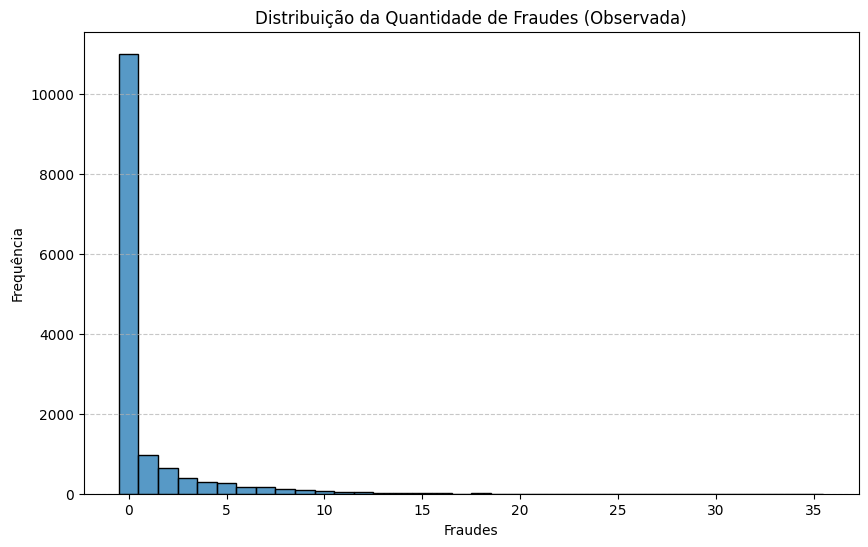

In [186]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.063733
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.056997
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


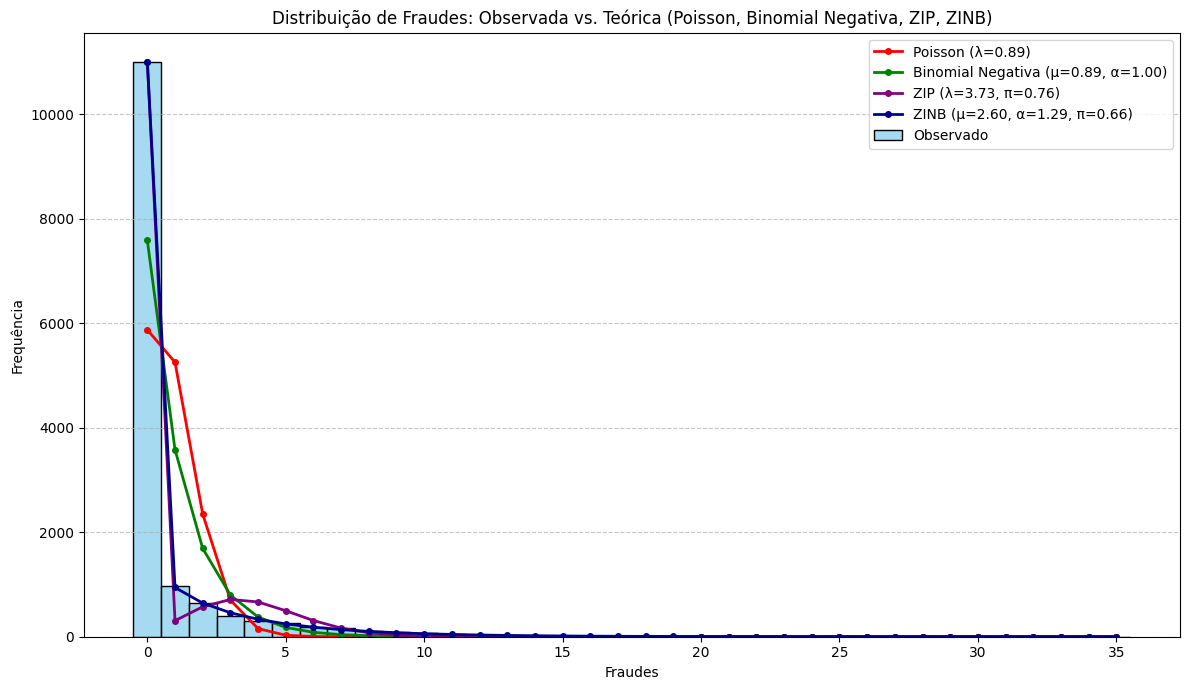

In [187]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

In [188]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [189]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [190]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [191]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [195]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Classe para seleção stepwise de features em modelos Zero-Inflated (ZIP/ZINB)
    compatível com scikit-learn.

    Esta classe implementa um algoritmo stepwise bidirecional que:
    - Testa cada feature tanto para o componente exógeno quanto inflacionado
    - Adiciona features que melhoram significativamente o modelo (p < alpha)
    - Remove features que perdem significância
    - Mantém controle rigoroso de multicolinearidade

    Parâmetros:
    -----------
    alpha : float, default=0.05
        Nível de significância para inclusão/exclusão de features
    model_type : str, default='ZIP'
        Tipo de modelo ('ZIP' para Zero-Inflated Poisson, 'ZINB' para Zero-Inflated Negative Binomial)
    selection_criterion : str, default='AIC'
        Critério para seleção de modelos ('AIC', 'BIC', ou 'LLF')
    max_iter : int, default=100
        Número máximo de iterações stepwise
    tolerance : float, default=1e-8
        Tolerância para convergência
    verbose : bool, default=False
        Se True, mostra detalhes do processo incluindo testes de significância
    model_params : dict, default=None
        Parâmetros adicionais para o modelo (ex: {'inflation': 'probit'})
    fit_params : dict, default=None
        Parâmetros para o fit do modelo (ex: {'cov_type': 'HC0'})
    validation_steps : bool, default=True
        Se True, realiza validação tripla para robustez

    Atributos:
    ----------
    columns_exog_ : list
        Features selecionadas para componente exógeno
    columns_inf_ : list
        Features selecionadas para componente inflacionado
    excluded_ : list
        Features excluídas por não atenderem critério de significância
    final_model_ : object
        Modelo final ajustado
    n_features_in_ : int
        Número de features de entrada
    feature_names_in_ : array
        Nomes das features de entrada
    criterion_history_ : list
        Histórico do critério de seleção durante stepwise
    step_history_ : list
        Histórico de passos do algoritmo
    """

    def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
                 tolerance=1e-8, verbose=False, model_params=None, fit_params=None, validation_steps=True):
        # Validação de parâmetros
        if not 0 < alpha < 1:
            raise ValueError("alpha deve estar entre 0 e 1")
        if model_type not in ['ZIP', 'ZINB']:
            raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
        if selection_criterion not in ['AIC', 'BIC', 'LLF']:
            raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
        if max_iter <= 0:
            raise ValueError("max_iter deve ser positivo")
        if tolerance <= 0:
            raise ValueError("tolerance deve ser positivo")

        self.alpha = alpha
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.model_params = model_params if model_params is not None else {}
        self.fit_params = fit_params if fit_params is not None else {}
        self.validation_steps = validation_steps

        # Configurar comportamento baseado no critério
        self._setup_criterion_behavior()

    def _setup_criterion_behavior(self):
        """Configura comportamento específico para cada critério de seleção."""
        if self.selection_criterion == 'LLF':
            warnings.warn(
                "LLF como critério de seleção pode levar a overfitting. "
                "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
                UserWarning
            )

    def _get_model_criterion(self, result):
        """
        Retorna o critério de seleção escolhido do resultado do modelo.

        Parâmetros:
        -----------
        result : statsmodels result object
            Resultado do modelo ajustado

        Retorna:
        --------
        criterion_value : float
            Valor do critério (menor é melhor para todos)
        """
        if self.selection_criterion == 'AIC':
            return result.aic
        elif self.selection_criterion == 'BIC':
            return result.bic
        elif self.selection_criterion == 'LLF':
            # Para LLF, usar valor negativo para manter lógica "menor é melhor"
            return -result.llf

    def _get_criterion_name(self):
        """Retorna nome amigável do critério para logs."""
        criterion_names = {
            'AIC': 'AIC',
            'BIC': 'BIC',
            'LLF': '-Log-Likelihood'
        }
        return criterion_names[self.selection_criterion]

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        self : object
            Instância ajustada
        """
        # Reset de atributos anteriores
        for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
                     'criterion_history_', 'step_history_']:
            if hasattr(self, attr):
                delattr(self, attr)

        # Preservar nomes originais das features se X for DataFrame
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Validação dos dados
        X, y = check_X_y(X, y, accept_sparse=False)

        # Validar y como contagens não-negativas
        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos (contagens)")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações dos dados
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        # Converter para DataFrame usando nomes originais
        X = pd.DataFrame(X, columns=original_feature_names)

        # Verificar se há features suficientes
        if X.shape[1] == 0:
            raise ValueError("X deve ter pelo menos uma feature")

        # Verificar variabilidade nas features
        for col in X.columns:
            if X[col].nunique() <= 1:
                warnings.warn(f"Feature '{col}' tem variabilidade zero ou constante")

        # Executar algoritmo stepwise
        try:
            result = self._stepwise_selection(X, y)
        except Exception as e:
            raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

        # Armazenar resultados
        self.columns_exog_ = result['columns_exog']
        self.columns_inf_ = result['columns_inf']
        self.excluded_ = result['excluded']
        self.criterion_history_ = result.get('criterion_history', [])
        self.step_history_ = result.get('step_history', [])

        # Ajustar modelo final
        try:
            self._fit_final_model(X, y)
        except Exception as e:
            warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
            self.final_model_ = None

        return self

    def transform(self, X):
        """
        Transforma os dados mantendo apenas as features selecionadas.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada

        Retorna:
        --------
        X_transformed : dict
            Dicionário com 'exog' e 'inf' contendo as features selecionadas
        """
        # Verificar se o modelo foi ajustado
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

        # Validar entrada
        X = check_array(X, accept_sparse=False)

        # Verificar dimensões
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

        # Converter para DataFrame se necessário
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Transformar dados
        result = {}

        if self.columns_exog_:
            result['exog'] = X[self.columns_exog_].values
        else:
            result['exog'] = np.empty((X.shape[0], 0))

        if self.columns_inf_:
            result['inf'] = X[self.columns_inf_].values
        else:
            result['inf'] = np.empty((X.shape[0], 0))

        return result

    def fit_transform(self, X, y):
        """
        Ajusta o modelo e transforma os dados.

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        X_transformed : dict
            Dicionário com 'exog' e 'inf' contendo as features selecionadas
        """
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """
        Retorna o critério de seleção do modelo final (negativo para que maior seja melhor).

        Parâmetros:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features de entrada
        y : array-like of shape (n_samples,)
            Variável target (contagens)

        Retorna:
        --------
        score : float
            -AIC do modelo final
        """
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não disponível")
        return -self._get_model_criterion(self.final_model_)

    def get_params(self, deep=True):
        """
        Obtém parâmetros para o estimador.
        """
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'verbose': self.verbose,
            'model_params': self.model_params,
            'fit_params': self.fit_params,
            'validation_steps': self.validation_steps
        }

    def set_params(self, **params):
        """
        Define parâmetros para o estimador.
        """
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        # Reconfigurar comportamento se critério mudou
        if 'selection_criterion' in params:
            self._setup_criterion_behavior()

        return self

    def _stepwise_selection(self, X, y):
        """
        Executa o algoritmo stepwise de seleção de features.
        """
        # Listas para acompanhar features
        columns_exog = []
        columns_inf = []
        excluded = []
        available_features = list(X.columns)

        # Histórico para debugging
        criterion_history = []
        step_history = []

        criterion_name = self._get_criterion_name()

        if self.verbose:
            print("INICIANDO PROCESSO STEPWISE")
            print(f"Modelo: {self.model_type}")
            print(f"Critério de seleção: {criterion_name}")
            print(f"Features disponíveis: {len(available_features)}")
            print(f"Dataset: {len(y)} observações, {np.sum(y == 0)} zeros ({np.sum(y == 0)/len(y)*100:.1f}%)")
            print("-" * 80)

        # Modelo inicial (apenas constante)
        try:
            initial_criterion = self._calculate_baseline_criterion(y)
            best_criterion = initial_criterion
            criterion_history.append(initial_criterion)

            if self.verbose:
                print(f"{criterion_name} inicial (modelo nulo): {initial_criterion:.2f}")
                print("-" * 80)
        except Exception as e:
            raise RuntimeError(f"Erro ao calcular {criterion_name} baseline: {str(e)}")

        # Loop principal stepwise
        for iteration in range(self.max_iter):
            improved = False

            if self.verbose:
                print(f"\nITERAÇÃO {iteration + 1}/{self.max_iter}")
                print(f"Processo Forward Selection: Testando features candidatas para inclusão no modelo")
                print(f"Status atual: {len(columns_exog)} exógenas, {len(columns_inf)} inflacionadas, {len(excluded)} excluídas")

            # Fase 1: Tentar adicionar features (Forward Selection)
            for feature in available_features[:]:
                if feature in columns_exog or feature in columns_inf or feature in excluded:
                    continue

                if self.verbose:
                    print(f"\nTestando feature: '{feature}'")
                    print(f"Critério de significância: p-valor < {self.alpha}")

                # Testar três cenários
                best_scenario_criterion = best_criterion
                best_scenario = None

                # Cenário 1: Como exógena
                temp_exog = columns_exog + [feature]
                temp_inf = columns_inf[:]
                criterion1, sig_info1 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                if criterion1 is not None and criterion1 < best_scenario_criterion:
                    best_scenario_criterion = criterion1
                    best_scenario = ('exog', temp_exog, temp_inf)
                    if self.verbose:
                        improvement = best_criterion - criterion1
                        print(f"EXÓGENA: {criterion_name} = {criterion1:.2f} (melhoria: {improvement:.2f})")
                elif self.verbose:
                    if criterion1 is None:
                        print(f"EXÓGENA: rejeitada ({sig_info1})")
                    else:
                        print(f"EXÓGENA: {criterion_name} = {criterion1:.2f} (pior que atual)")

                # Cenário 2: Como inflacionada
                temp_exog = columns_exog[:]
                temp_inf = columns_inf + [feature]
                criterion2, sig_info2 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                if criterion2 is not None and criterion2 < best_scenario_criterion:
                    best_scenario_criterion = criterion2
                    best_scenario = ('inf', temp_exog, temp_inf)
                    if self.verbose:
                        improvement = best_criterion - criterion2
                        print(f"INFLACIONADA: {criterion_name} = {criterion2:.2f} (melhoria: {improvement:.2f})")
                elif self.verbose:
                    if criterion2 is None:
                        print(f"INFLACIONADA: rejeitada ({sig_info2})")
                    else:
                        print(f"INFLACIONADA: {criterion_name} = {criterion2:.2f} (pior que atual)")

                # Cenário 3: Em ambas (se aplicável)
                if len(columns_exog) > 0 or len(columns_inf) > 0:
                    temp_exog = columns_exog + [feature]
                    temp_inf = columns_inf + [feature]
                    criterion3, sig_info3 = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion3 is not None and criterion3 < best_scenario_criterion:
                        best_scenario_criterion = criterion3
                        best_scenario = ('both', temp_exog, temp_inf)
                        if self.verbose:
                            improvement = best_criterion - criterion3
                            print(f"AMBAS PARTES: {criterion_name} = {criterion3:.2f} (melhoria: {improvement:.2f})")
                    elif self.verbose:
                        if criterion3 is None:
                            print(f"AMBAS PARTES: rejeitada ({sig_info3})")
                        else:
                            print(f"AMBAS PARTES: {criterion_name} = {criterion3:.2f} (pior que atual)")

                # Aplicar melhor cenário se houver melhoria
                if best_scenario is not None:
                    scenario_type, new_exog, new_inf = best_scenario
                    columns_exog = new_exog
                    columns_inf = new_inf
                    best_criterion = best_scenario_criterion
                    improved = True

                    step_history.append({
                        'iteration': iteration + 1,
                        'action': 'add',
                        'feature': feature,
                        'scenario': scenario_type,
                        'criterion': best_scenario_criterion,
                        'criterion_name': criterion_name
                    })

                    if self.verbose:
                        scenario_map = {'exog': 'EXÓGENA', 'inf': 'INFLACIONADA', 'both': 'AMBAS PARTES'}
                        print(f"FEATURE ADICIONADA como {scenario_map[scenario_type]}: '{feature}'")
                    break
                else:
                    excluded.append(feature)
                    if self.verbose:
                        print(f"FEATURE EXCLUÍDA: '{feature}' (nenhum cenário atendeu critério α={self.alpha})")

            # Fase 2: Tentar remover features (Backward Elimination)
            if self.verbose and (columns_exog or columns_inf):
                print(f"\nProcesso Backward Elimination: Verificando se features perderam significância")

            removed_any = True
            while removed_any:
                removed_any = False

                # Testar remoção de features exógenas
                for feature in columns_exog[:]:
                    temp_exog = [f for f in columns_exog if f != feature]
                    temp_inf = columns_inf[:]
                    criterion_without, _ = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion_without is not None and criterion_without <= best_criterion:
                        columns_exog = temp_exog
                        best_criterion = criterion_without
                        excluded.append(feature)
                        removed_any = True

                        step_history.append({
                            'iteration': iteration + 1,
                            'action': 'remove',
                            'feature': feature,
                            'from': 'exog',
                            'criterion': criterion_without,
                            'criterion_name': criterion_name
                        })

                        if self.verbose:
                            print(f"REMOVIDA de EXÓGENAS: '{feature}' (perdeu significância, {criterion_name}: {criterion_without:.2f})")
                        break

                # Testar remoção de features inflacionadas
                for feature in columns_inf[:]:
                    temp_exog = columns_exog[:]
                    temp_inf = [f for f in columns_inf if f != feature]
                    criterion_without, _ = self._test_feature_combination(X, y, temp_exog, temp_inf)

                    if criterion_without is not None and criterion_without <= best_criterion:
                        columns_inf = temp_inf
                        best_criterion = criterion_without
                        excluded.append(feature)
                        removed_any = True

                        step_history.append({
                            'iteration': iteration + 1,
                            'action': 'remove',
                            'feature': feature,
                            'from': 'inf',
                            'criterion': criterion_without,
                            'criterion_name': criterion_name
                        })

                        if self.verbose:
                            print(f"REMOVIDA de INFLACIONADAS: '{feature}' (perdeu significância, {criterion_name}: {criterion_without:.2f})")
                        break

            criterion_history.append(best_criterion)

            # Verificar convergência
            if not improved and len(criterion_history) > 1:
                criterion_change = abs(criterion_history[-2] - criterion_history[-1])
                if criterion_change < self.tolerance:
                    if self.verbose:
                        print(f"\nCONVERGÊNCIA ATINGIDA (mudança {criterion_name}: {criterion_change:.6f} < {self.tolerance})")
                    break

            if not improved:
                if self.verbose:
                    print(f"\nPROCESSO FINALIZADO: Nenhuma melhoria possível na iteração {iteration + 1}")
                break

        if self.verbose:
            print(f"\n" + "=" * 80)
            print(f"PROCESSO STEPWISE FINALIZADO")
            print("-" * 80)
            print(f"Features EXÓGENAS ({len(columns_exog)}): {columns_exog}")
            print(f"Features INFLACIONADAS ({len(columns_inf)}): {columns_inf}")
            print(f"Features EXCLUÍDAS ({len(excluded)}): {excluded}")
            print(f"{criterion_name} final: {best_criterion:.2f} (melhoria total: {initial_criterion - best_criterion:.2f})")
            print("=" * 80)

        return {
            'columns_exog': columns_exog,
            'columns_inf': columns_inf,
            'excluded': excluded,
            'criterion_history': criterion_history,
            'step_history': step_history
        }

    def _test_feature_combination(self, X, y, exog_features, inf_features):
        """
        Testa uma combinação específica de features com validação hierárquica.
        PARA na primeira validação que falhar, mantendo modelo intacto.

        Retorna:
        --------
        tuple: (aic, sig_info) onde aic é None se falhou em qualquer momento
        """
        try:
            # Preparar matrizes
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Verificar dimensões das matrizes
            if X1.shape[0] != len(y) or X2.shape[0] != len(y):
                raise ValueError("Dimensões incompatíveis entre X e y")

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo APENAS para teste inicial
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # MOMENTO 1: Verificação Inicial de Significância
            if self.verbose:
                print(f"    MOMENTO 1 - Validação inicial de significância")

            is_significant, sig_details = self._validate_all_features_significance(
                result, exog_features, inf_features, "inicial"
            )

            if not is_significant:
                if self.verbose:
                    print(f"    REJEITADA no Momento 1: {sig_details}")
                    print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                return None, f"Momento 1 - {sig_details}"

            # MOMENTO 2: Validação de Estabilidade (só se passou no Momento 1)
            if self.validation_steps and len(exog_features) + len(inf_features) > 1:
                if self.verbose:
                    print(f"    MOMENTO 2 - Validação de estabilidade")

                criterion_value = self._get_model_criterion(result)
                stability_passed, stability_details = self._validate_model_stability(
                    X, y, exog_features, inf_features, criterion_value
                )

                if not stability_passed:
                    if self.verbose:
                        print(f"    REJEITADA no Momento 2: {stability_details}")
                        print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                    return None, f"Momento 2 - {stability_details}"
            else:
                if self.verbose:
                    print(f"    MOMENTO 2 - Pulado (apenas uma feature ou validação desabilitada)")

            # MOMENTO 3: Validação Final Robusta (só se passou nos anteriores)
            if self.validation_steps:
                if self.verbose:
                    print(f"    MOMENTO 3 - Validação final robusta")

                final_criterion, final_valid, final_details = self._validate_final_robustness(
                    X, y, exog_features, inf_features
                )

                if not final_valid:
                    if self.verbose:
                        print(f"    REJEITADA no Momento 3: {final_details}")
                        print(f"    MODELO MANTIDO INTACTO (feature não incluída)")
                    return None, f"Momento 3 - {final_details}"

                # Usar critério da validação final
                final_criterion_to_return = final_criterion
            else:
                final_criterion_to_return = self._get_model_criterion(result)

            # SUCESSO: Passou em todos os momentos
            if self.verbose:
                criterion_name = self._get_criterion_name()
                print(f"    APROVADA em todos os momentos!")
                print(f"    Feature será INCLUÍDA no modelo ({criterion_name}: {final_criterion_to_return:.2f})")

            return final_criterion_to_return, "aprovada em todos os momentos de validação"

        except Exception as e:
            error_msg = f"erro no modelo: {str(e)[:50]}..."
            if self.verbose:
                print(f"    ERRO na validação: {error_msg}")
                print(f"    MODELO MANTIDO INTACTO")
            return None, error_msg

    def _validate_all_features_significance(self, result, exog_features, inf_features, momento=""):
        """Validação Momento 1: Verifica se todas as features são significativas."""
        try:
            non_significant_features = []

            # Verificar se temos p-values suficientes
            expected_params = 1 + len(exog_features) + 1 + len(inf_features)  # constantes + features
            if len(result.pvalues) < expected_params:
                return False, f"número insuficiente de parâmetros no modelo ({momento})"

            # Verificar features exógenas (exceto constante)
            for i, feature in enumerate(exog_features):
                try:
                    p_value = result.pvalues[i + 1]  # +1 para pular constante
                    if pd.isna(p_value) or p_value >= self.alpha:
                        non_significant_features.append(f"{feature} (exog, p={p_value:.4f})")
                except (IndexError, KeyError):
                    non_significant_features.append(f"{feature} (exog, erro no p-valor)")

            # Verificar features inflacionadas (exceto constante)
            n_exog = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                try:
                    p_value = result.pvalues[n_exog + i + 1]  # +1 para pular constante inflacionada
                    if pd.isna(p_value) or p_value >= self.alpha:
                        non_significant_features.append(f"{feature} (inf, p={p_value:.4f})")
                except (IndexError, KeyError):
                    non_significant_features.append(f"{feature} (inf, erro no p-valor)")

            # Preparar detalhes
            if non_significant_features:
                details = f"features não significativas ({momento}): {', '.join(non_significant_features)}"
                if self.verbose:
                    print(f"    {momento.upper()} - Features com p >= {self.alpha}: {', '.join(non_significant_features)}")
                return False, details
            else:
                if self.verbose and momento:
                    print(f"    {momento.upper()} - Todas features significativas (p < {self.alpha})")
                return True, f"todas features significativas ({momento})"

        except Exception as e:
            return False, f"erro na validação de significância ({momento}): {str(e)}"

    def _validate_model_stability(self, X, y, exog_features, inf_features, baseline_criterion):
        """Validação Momento 2: Testa estabilidade do modelo."""
        try:
            all_features = list(set(exog_features + inf_features))
            unstable_features = []

            if self.verbose:
                print(f"        Testando estabilidade com {len(all_features)} features")

            for feature in all_features:
                try:
                    # Criar modelo sem esta feature
                    temp_exog = [f for f in exog_features if f != feature]
                    temp_inf = [f for f in inf_features if f != feature]

                    # Se remove todas as features, pular este teste
                    if not temp_exog and not temp_inf:
                        continue

                    # Testar modelo reduzido APENAS para estabilidade
                    criterion_without, sig_info = self._test_feature_combination_simple(X, y, temp_exog, temp_inf)

                    if criterion_without is None:
                        unstable_features.append(f"{feature} (modelo instável sem ela)")
                        if self.verbose:
                            print(f"        Feature '{feature}' causa instabilidade se removida")
                        continue

                    # Verificar deterioração excessiva baseada no critério
                    criterion_deterioration = criterion_without - baseline_criterion

                    # Limiar adaptativo baseado no critério
                    if self.selection_criterion == 'LLF':
                        # Para LLF (negativo), deterioração de 5 pontos
                        deterioration_threshold = 5
                    else:
                        # Para AIC/BIC, deterioração de 10 pontos
                        deterioration_threshold = 10

                    if criterion_deterioration > deterioration_threshold:
                        if self.verbose:
                            criterion_name = self._get_criterion_name()
                            print(f"        Feature '{feature}' essencial (Δ{criterion_name}: {criterion_deterioration:.2f})")

                except Exception as e:
                    unstable_features.append(f"{feature} (erro: {str(e)[:30]})")
                    if self.verbose:
                        print(f"        Erro testando '{feature}': {str(e)[:30]}")

            if unstable_features:
                details = f"features causam instabilidade: {', '.join(unstable_features)}"
                if self.verbose:
                    print(f"        Modelo instável: {details}")
                return False, details
            else:
                if self.verbose:
                    print(f"        Modelo estável com todas as features")
                return True, "modelo estável"

        except Exception as e:
            return False, f"erro na validação de estabilidade: {str(e)}"

    def _validate_final_robustness(self, X, y, exog_features, inf_features):
        """Validação Momento 3: Validação final robusta."""
        try:
            if self.verbose:
                print(f"        Executando validação final robusta")

            # Verificar multicolinearidade ANTES de reajustar
            multicolinearity_issues = []

            if exog_features and len(exog_features) > 1:
                X1 = X[exog_features].copy()
                # Verificar se há variabilidade suficiente
                if X1.var().min() == 0:
                    return None, False, "feature sem variabilidade detectada"

                corr_matrix = X1.corr().abs()
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        if not pd.isna(corr_matrix.iloc[i, j]) and corr_matrix.iloc[i, j] > 0.9:
                            multicolinearity_issues.append(
                                f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]} (r={corr_matrix.iloc[i, j]:.3f})"
                            )

            if inf_features and len(inf_features) > 1:
                X2 = X[inf_features].copy()
                # Verificar se há variabilidade suficiente
                if X2.var().min() == 0:
                    return None, False, "feature sem variabilidade detectada"

                corr_matrix = X2.corr().abs()
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        if not pd.isna(corr_matrix.iloc[i, j]) and corr_matrix.iloc[i, j] > 0.9:
                            multicolinearity_issues.append(
                                f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]} (r={corr_matrix.iloc[i, j]:.3f})"
                            )

            if multicolinearity_issues:
                details = f"multicolinearidade detectada: {', '.join(multicolinearity_issues)}"
                if self.verbose:
                    print(f"        {details}")
                return None, False, details

            # Preparar matrizes finais
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Reajustar modelo final
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                return None, False, f"model_type '{self.model_type}' não suportado"

            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Validação final de significância
            is_significant, sig_details = self._validate_all_features_significance(
                result, exog_features, inf_features, "final"
            )

            if not is_significant:
                if self.verbose:
                    print(f"        Perdeu significância no reajuste: {sig_details}")
                return None, False, sig_details

            # Verificar convergência
            if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
                details = "modelo não convergiu na validação final"
                if self.verbose:
                    print(f"        {details}")
                return None, False, details

            # Obter critério final
            final_criterion = self._get_model_criterion(result)
            criterion_name = self._get_criterion_name()

            if self.verbose:
                print(f"        Validação final aprovada ({criterion_name}: {final_criterion:.2f})")

            return final_criterion, True, "validação final robusta aprovada"

        except Exception as e:
            error_details = f"erro na validação final: {str(e)[:50]}"
            if self.verbose:
                print(f"        {error_details}")
            return None, False, error_details

    def _test_feature_combination_simple(self, X, y, exog_features, inf_features):
        """Versão simplificada para testes internos de validação."""
        try:
            if exog_features:
                X1 = X[exog_features].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if inf_features:
                X2 = X[inf_features].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                return None, f"model_type '{self.model_type}' não suportado"

            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            criterion_value = self._get_model_criterion(result)
            return criterion_value, "ajustado"

        except Exception:
            return None, "erro no ajuste"

    def _calculate_baseline_criterion(self, y):
        """Calcula o critério baseline do modelo nulo (apenas constante)."""
        try:
            # Criar matriz de constantes para ambos os componentes
            n_obs = len(y)
            X_const = pd.DataFrame({'const': np.ones(n_obs)})

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo baseline (apenas constantes)
            model = ModelClass(
                y,
                exog=X_const,           # Componente exógeno apenas com constante
                exog_infl=X_const,      # Componente inflacionado apenas com constante
                **self.model_params
            )

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**self.fit_params)

            # Obter critério baseline
            baseline_criterion = self._get_model_criterion(result)
            criterion_name = self._get_criterion_name()

            if self.verbose:
                zero_count = np.sum(y == 0)
                zero_pct = zero_count / len(y) * 100
                print(f"Modelo baseline ajustado:")
                print(f"  - Observações: {len(y)}")
                print(f"  - Zeros: {zero_count} ({zero_pct:.1f}%)")
                print(f"  - {criterion_name} baseline: {baseline_criterion:.2f}")
                print(f"  - Convergiu: {result.mle_retvals.get('converged', 'N/A')}")

            return baseline_criterion

        except Exception as e:
            # Em caso de erro, usar um critério alto como fallback
            if self.selection_criterion in ['AIC', 'BIC']:
                fallback_criterion = len(y) * 10  # Critério conservadoramente alto
            else:  # LLF
                fallback_criterion = len(y) * 5   # Critério alto para -LLF

            criterion_name = self._get_criterion_name()

            if self.verbose:
                print(f"Erro ao calcular {criterion_name} baseline: {str(e)}")
                print(f"Usando {criterion_name} fallback: {fallback_criterion:.2f}")

            return fallback_criterion

    def _fit_final_model(self, X, y):
        """Ajusta o modelo final com as features selecionadas."""
        try:
            # Preparar matrizes para o modelo final
            if self.columns_exog_:
                X1 = X[self.columns_exog_].copy()
                X1 = sm.add_constant(X1, has_constant='add')
            else:
                X1 = pd.DataFrame({'const': np.ones(len(X))})

            if self.columns_inf_:
                X2 = X[self.columns_inf_].copy()
                X2 = sm.add_constant(X2, has_constant='add')
            else:
                X2 = pd.DataFrame({'const': np.ones(len(X))})

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo final
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.final_model_ = model.fit(**self.fit_params)

            if self.verbose:
                criterion_name = self._get_criterion_name()
                final_criterion = self._get_model_criterion(self.final_model_)
                print(f"\nMODELO FINAL AJUSTADO:")
                print(f"  - {criterion_name}: {final_criterion:.2f}")
                print(f"  - Features exógenas: {len(self.columns_exog_)}")
                print(f"  - Features inflacionadas: {len(self.columns_inf_)}")
                print(f"  - Convergiu: {self.final_model_.mle_retvals.get('converged', 'N/A')}")

        except Exception as e:
            if self.verbose:
                print(f"Erro ao ajustar modelo final: {str(e)}")

            # Em caso de erro, definir modelo como None
            self.final_model_ = None
            raise RuntimeError(f"Falha ao ajustar modelo final: {str(e)}")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [196]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.894103,5.224894


Há indícios de superdispersão.

In [197]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ std_amount + mean_current_age + std_current_age + mean_total_debt + mean_credit_score + std_credit_score + mean_num_credit_cards + std_num_credit_cards + mean_credit_limit + gender_male + card_brand_amex + card_brand_discover + card_type_debit_prepaid + has_chip_no + category_arts_entertainment_recreation + category_health_medical + category_sports_recreation + category_travel_hospitality + category_retail_clothing_accessories + category_professional_business_services + category_financial_insurance + category_retail_specialty + category_retail_home_garden + category_construction_contractors + category_personal_services'

In [198]:
result_tests = {}
for column in X.columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'category_travel_hospitality'

In [199]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26464.
Date:                Fri, 30 May 2025   Deviance:                       43109.
Time:                        21:04:33   Pearson chi2:                 3.19e+08
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1534
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0633      0.009      7.163      0.000       0.046       0.081
category_travel_hospitality   -78.5750      0.041  -1894.959      0.000     -78.656     -78.494
===============================================================================================
"""

Observações do modelo simples

//TODO: Incluir analise posteriormente



In [200]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14333
Model Family:                 Poisson   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24157.
Date:                Fri, 30 May 2025   Deviance:                       38494.
Time:                        21:04:34   Pearson chi2:                 3.85e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3859
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -22.1100      2.669     -8.284      0.000     -27.341     -16.879
std_amount                                  0.0020      0.001      3.775      0.000       0.001       0.003
mean_current_age                            0.1055      0.014      7.674      0.000       0.079       0.132
std_current_age                             0.3795      0.020     19.257      0.000       0.341       0.418
mean_total_debt                              1e-05   4.93e-06      2.030      0.042    3.43e-07    1.97e-05
mean_credit_score                           0.0135      0.003      3.864      0.000       0.007       0.020
std_credit_score                            0.0297      0.004      7.358      0.000       0.022       0.038
mean_num_credit_cards                       0.2315      0.154      1.501      0.133      -0.071       0.534
std_num_credit_cards                       -1.6731      0.205     -8.157      0.000      -2.075      -1.271
mean_credit_limit                       -2.347e-05   1.94e-05     -1.207      0.227   -6.16e-05    1.46e-05
gender_male                                 1.2095      0.425      2.845      0.004       0.376       2.043
card_brand_amex                            -4.6073      0.820     -5.617      0.000      -6.215      -3.000
card_brand_discover                         2.3468      1.179      1.991      0.046       0.037       4.657
card_type_debit_prepaid                     3.1986      0.789      4.052      0.000       1.651       4.746
has_chip_no                                 1.8454      0.663      2.784      0.005       0.546       3.145
category_arts_entertainment_recreation    -13.5753      0.808    -16.808      0.000     -15.158     -11.992
category_health_medical                    -0.7367      0.716     -1.029      0.304      -2.140       0.667
category_sports_recreation                -26.9776      2.124    -12.703      0.000     -31.140     -22.815
category_travel_hospitality               -57.1178      2.928    -19.508      0.000     -62.856     -51.379
category_retail_clothing_accessories       -1.3099      1.739     -0.753      0.451      -4.719       2.099
category_professional_business_services   -31.7242      1.485    -21.365      0.000     -34.634     -28.814
category_financial_insurance                0.3074      0.918      0.335      0.738      -1.493       2.107
category_retail_specialty                   0.1449      0.880      0.165      0.869      -1.579       1.869
category_retail_home_garden                -8.8184      1.047     -8.420      0.000     -10.871      -6.766
category_construction_contractors         -57.1698     16.218     -3.525      0.000     -88.956     -25.384
category_personal_services                 26.7994      1.5

In [201]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.040      
Dependent Variable:     ystar            AIC:                         122760.1518
Date:                   2025-05-30 21:04 BIC:                         122767.7239
No. Observations:       14359            Log-Likelihood:              -61379.    
Df Model:               1                F-statistic:                 601.8      
Df Residuals:           14358            Prob (F-statistic):          3.22e-130  
R-squared (uncentered): 0.040            Scale:                       302.30     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.2111         0.1309       24.5313       0.0000       2.9546    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [202]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('mean_credit_limit') + Q('gender_male') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_arts_entertainment_recreation') + Q('category_health_medical') + Q('category_sports_recreation') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_professional_business_services') + Q('category_financial_insurance') + Q('category_retail_specialty') + Q('category_retail_home_garden') + Q('category_construction_contractors') + Q('category_personal_services')

 Family type...: 
 Poisson

 Discarding atribute "Q('category_retail_specialty')" with p-value equal to 0.8691469315033299 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('mean_current_a

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14340
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24161.
Date:                Fri, 30 May 2025   Deviance:                       38502.
Time:                        21:04:37   Pearson chi2:                 4.57e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3855
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -21.6076      2.558     -8.446      0.000     -26.622     -16.593
Q('std_amount')                                  0.0020      0.001      3.797      0.000       0.001       0.003
Q('mean_current_age')                            0.1060      0.012      9.177      0.000       0.083       0.129
Q('std_current_age')                             0.3653      0.018     19.754      0.000       0.329       0.402
Q('mean_credit_score')                           0.0143      0.003      4.213      0.000       0.008       0.021
Q('std_credit_score')                            0.0300      0.004      7.523      0.000       0.022       0.038
Q('std_num_credit_cards')                       -1.5853      0.200     -7.914      0.000      -1.978      -1.193
Q('gender_male')                                 1.2232      0.424      2.884      0.004       0.392       2.055
Q('card_brand_amex')                            -4.4812      0.810     -5.530      0.000      -6.069      -2.893
Q('card_brand_discover')                         2.4182      1.174      2.059      0.039       0.116       4.720
Q('card_type_debit_prepaid')                     3.5862      0.720      4.978      0.000       2.174       4.998
Q('has_chip_no')                                 1.8463      0.662      2.788      0.005       0.548       3.144
Q('category_arts_entertainment_recreation')    -13.6265      0.707    -19.273      0.000     -15.012     -12.241
Q('category_sports_recreation')                -26.7976      2.110    -12.700      0.000     -30.933     -22.662
Q('category_travel_hospitality')               -57.1406      2.918    -19.581      0.000     -62.860     -51.421
Q('category_professional_business_services')   -31.6067      1.478    -21.389      0.000     -34.503     -28.710
Q('category_retail_home_garden')                -8.9184      1.034     -8.623      0.000     -10.945      -6.891
Q('category_construction_contractors')         -56.6323     16.205     -3.495      0.000     -88.393     -24.872
Q('category_personal_services')                 26.3696      1.520     17.351      0.000      23.391      29.348
================================================================================================================
"""

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [203]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.040      
Dependent Variable:     ystar            AIC:                         122730.2577
Date:                   2025-05-30 21:04 BIC:                         122737.8298
No. Observations:       14359            Log-Likelihood:              -61364.    
Df Model:               1                F-statistic:                 603.6      
Df Residuals:           14358            Prob (F-statistic):          1.33e-130  
R-squared (uncentered): 0.040            Scale:                       301.67     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.2138         0.1308       24.5689       0.0000       2.9574    

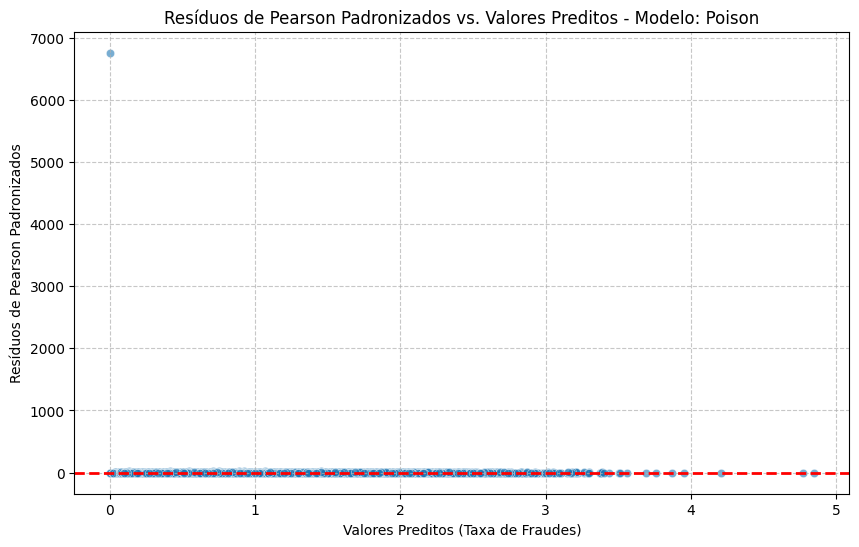

In [204]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [205]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,0.0633***,-22.1100***,-21.6076***
,(0.0088),(2.6689),(2.5584)
category_travel_hospitality,-78.5750***,-57.1178***,
,(0.0415),(2.9279),
std_amount,,0.0020***,
,,(0.0005),
mean_current_age,,0.1055***,
,,(0.0138),
std_current_age,,0.3795***,
,,(0.0197),


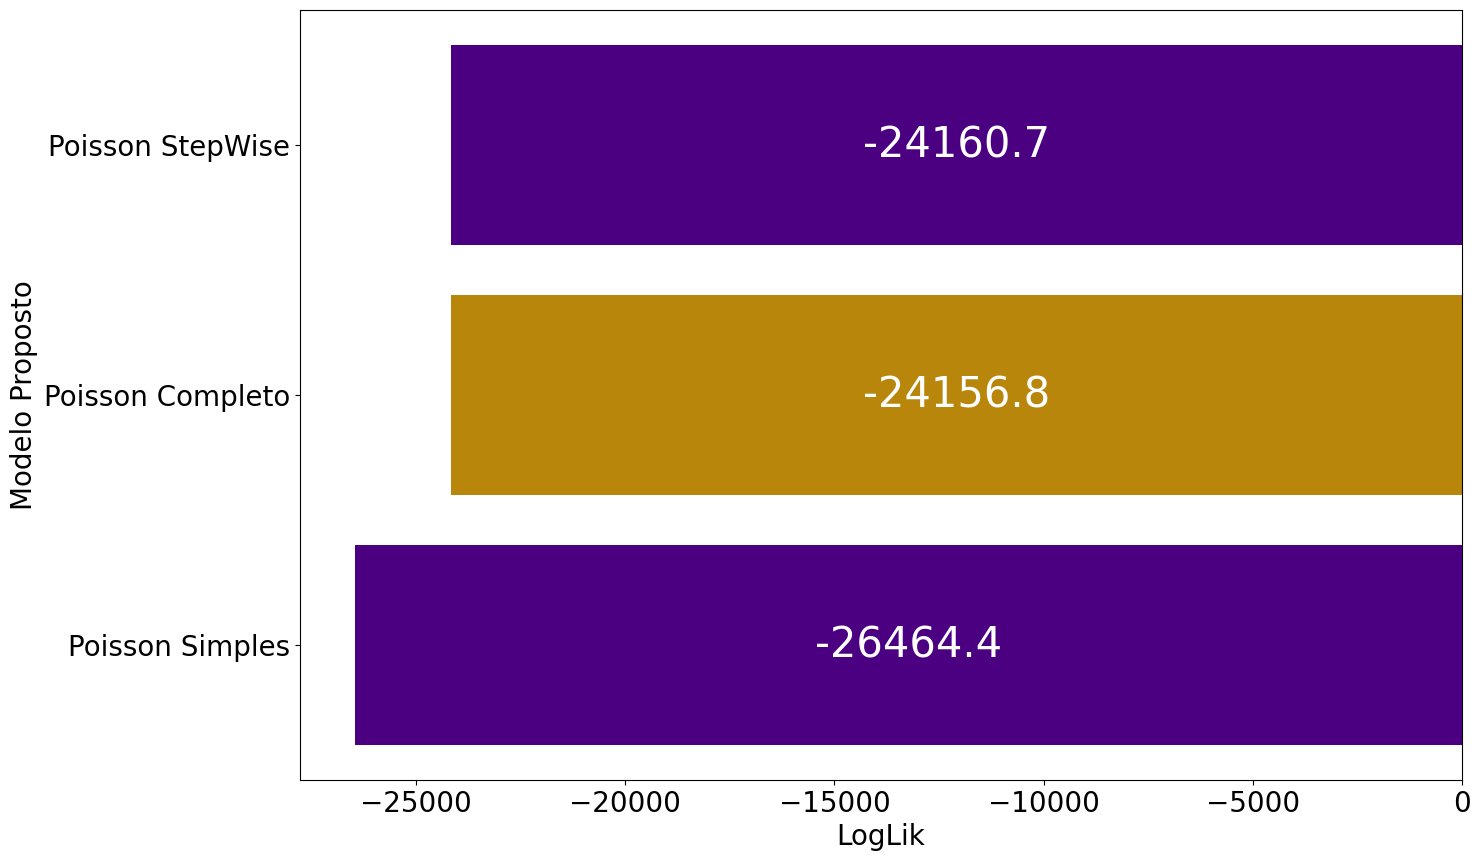

In [206]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [207]:
result_tests = {}
for column in X.columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.pseudo_rsquared()
column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'category_travel_hospitality'

In [208]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18068.
Date:                Fri, 30 May 2025   Deviance:                       21301.
Time:                        21:04:38   Pearson chi2:                 1.86e+12
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09871
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.1038      0.013      7.696      0.000       0.077       0.130
category_travel_hospitality  -113.4130      3.233    -35.077      0.000    -119.750    -107.076
===============================================================================================
"""

In [209]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14333
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16810.
Date:                Fri, 30 May 2025   Deviance:                       18785.
Time:                        21:04:38   Pearson chi2:                 2.00e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2433
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -24.6585      3.693     -6.678      0.000     -31.896     -17.421
std_amount                                  0.0015      0.001      1.906      0.057   -4.21e-05       0.003
mean_current_age                            0.1363      0.019      7.118      0.000       0.099       0.174
std_current_age                             0.3791      0.027     13.810      0.000       0.325       0.433
mean_total_debt                          1.094e-05   6.82e-06      1.603      0.109   -2.43e-06    2.43e-05
mean_credit_score                           0.0138      0.005      2.843      0.004       0.004       0.023
std_credit_score                            0.0353      0.006      6.325      0.000       0.024       0.046
mean_num_credit_cards                       0.2106      0.214      0.985      0.324      -0.208       0.629
std_num_credit_cards                       -1.9180      0.284     -6.759      0.000      -2.474      -1.362
mean_credit_limit                       -2.768e-07   2.72e-05     -0.010      0.992   -5.35e-05    5.29e-05
gender_male                                 1.3248      0.587      2.256      0.024       0.174       2.476
card_brand_amex                            -3.3277      1.134     -2.934      0.003      -5.551      -1.104
card_brand_discover                         1.5302      1.648      0.929      0.353      -1.700       4.760
card_type_debit_prepaid                     5.6083      1.107      5.067      0.000       3.439       7.778
has_chip_no                                 1.8173      0.920      1.976      0.048       0.015       3.620
category_arts_entertainment_recreation    -12.3323      0.997    -12.367      0.000     -14.287     -10.378
category_health_medical                    -0.8887      1.000     -0.889      0.374      -2.848       1.070
category_sports_recreation                -26.5882      2.863     -9.288      0.000     -32.199     -20.978
category_travel_hospitality               -52.8446      3.590    -14.720      0.000     -59.881     -45.808
category_retail_clothing_accessories       -1.2216      2.467     -0.495      0.621      -6.057       3.614
category_professional_business_services   -36.0464      2.071    -17.405      0.000     -40.105     -31.987
category_financial_insurance                2.0372      1.294      1.575      0.115      -0.498       4.573
category_retail_specialty                  -0.2733      1.236     -0.221      0.825      -2.696       2.149
category_retail_home_garden                -9.4833      1.450     -6.538      0.000     -12.326      -6.640
category_construction_contractors         -35.0384     17.849     -1.963      0.050     -70.021      -0.056
category_personal_services                 32.5040      2.3

In [210]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('mean_credit_limit') + Q('gender_male') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_arts_entertainment_recreation') + Q('category_health_medical') + Q('category_sports_recreation') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_professional_business_services') + Q('category_financial_insurance') + Q('category_retail_specialty') + Q('category_retail_home_garden') + Q('category_construction_contractors') + Q('category_personal_services')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('mean_credit_limit')" with p-value equal to 0.9918677908038642 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('mean_current

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14359
Model:                            GLM   Df Residuals:                    14341
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16814.
Date:                Fri, 30 May 2025   Deviance:                       18792.
Time:                        21:04:39   Pearson chi2:                 2.15e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2430
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -23.0080      3.542     -6.495      0.000     -29.951     -16.065
Q('std_amount')                                  0.0016      0.001      2.030      0.042    5.38e-05       0.003
Q('mean_current_age')                            0.1348      0.016      8.311      0.000       0.103       0.167
Q('std_current_age')                             0.3662      0.026     14.146      0.000       0.315       0.417
Q('mean_credit_score')                           0.0137      0.005      2.908      0.004       0.004       0.023
Q('std_credit_score')                            0.0366      0.005      6.678      0.000       0.026       0.047
Q('std_num_credit_cards')                       -1.8534      0.277     -6.701      0.000      -2.396      -1.311
Q('gender_male')                                 1.3784      0.585      2.356      0.018       0.232       2.525
Q('card_brand_amex')                            -3.3138      1.119     -2.961      0.003      -5.507      -1.120
Q('card_type_debit_prepaid')                     5.4709      1.006      5.437      0.000       3.499       7.443
Q('has_chip_no')                                 1.8674      0.918      2.035      0.042       0.069       3.666
Q('category_arts_entertainment_recreation')    -12.0303      0.862    -13.962      0.000     -13.719     -10.342
Q('category_sports_recreation')                -26.1182      2.841     -9.193      0.000     -31.687     -20.550
Q('category_travel_hospitality')               -52.9870      3.574    -14.824      0.000     -59.993     -45.981
Q('category_professional_business_services')   -36.2563      2.059    -17.606      0.000     -40.293     -32.220
Q('category_retail_home_garden')                -9.5026      1.431     -6.642      0.000     -12.307      -6.699
Q('category_construction_contractors')         -35.8781     17.841     -2.011      0.044     -70.846      -0.910
Q('category_personal_services')                 32.5585      2.200     14.797      0.000      28.246      36.871
================================================================================================================
"""

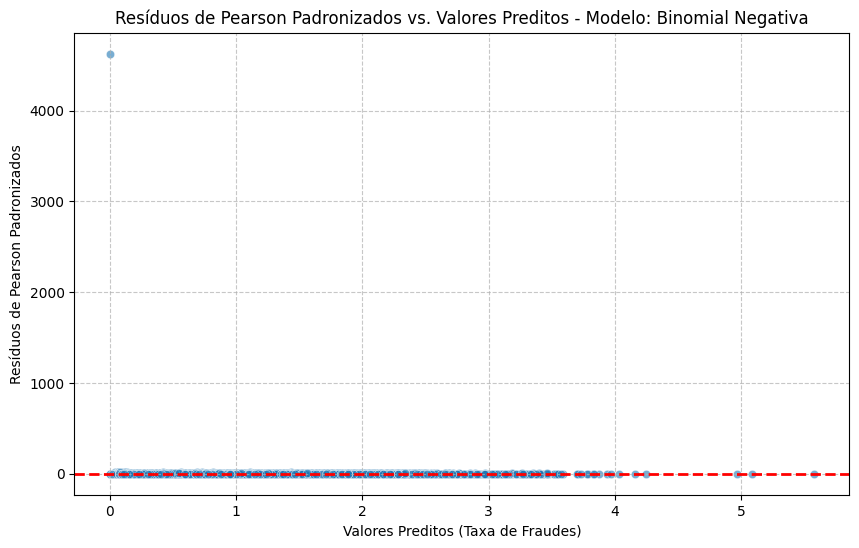

In [211]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [212]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 14694.03
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


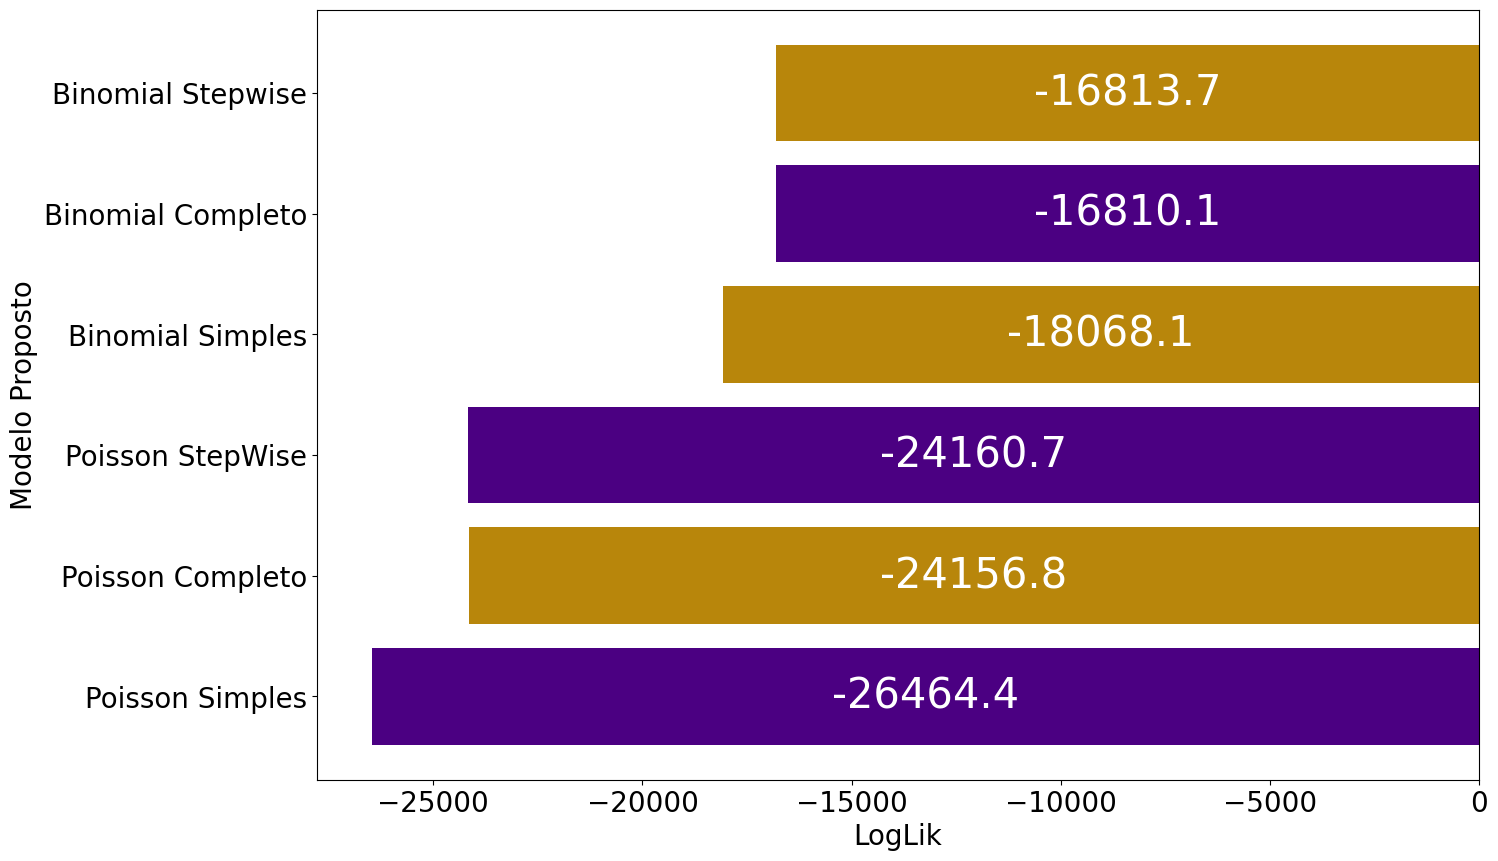

In [213]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [214]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,mean_credit_limit,gender_male,...,category_health_medical,category_sports_recreation,category_travel_hospitality,category_retail_clothing_accessories,category_professional_business_services,category_financial_insurance,category_retail_specialty,category_retail_home_garden,category_construction_contractors,category_personal_services
0,3.864859,4.018701,2.781098,10.972032,6.575393,4.207079,1.598775,0.914125,9.684469,0.392042,...,0.029559,0.019803,0.00995,0.019803,0.009950,0.067659,0.039221,0.00000,0.0,0.0
1,4.104008,4.035644,2.774908,10.945473,6.575180,4.195467,1.605247,0.937929,9.620037,0.392042,...,0.039221,0.009950,0.00000,0.000000,0.000000,0.048790,0.019803,0.00995,0.0,0.0
2,4.421440,4.049284,2.849613,10.902716,6.575291,4.173661,1.585391,0.942696,9.664143,0.405465,...,0.029559,0.009950,0.00995,0.009950,0.000000,0.048790,0.009950,0.00995,0.0,0.0
3,4.139706,4.032765,2.757838,10.896100,6.564211,4.235561,1.575105,0.933053,9.612056,0.385262,...,0.019803,0.019803,0.00000,0.009950,0.000000,0.048790,0.000000,0.00995,0.0,0.0
4,4.813856,4.031286,2.684104,10.957843,6.574422,4.098220,1.589419,0.923981,9.580258,0.438255,...,0.076961,0.019803,0.00000,0.000000,0.029559,0.048790,0.039221,0.04879,0.0,0.0


In [215]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [216]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped)

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.columns).drop(columns='frauds')
X_scaler.head()

,mean_current_age,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,gender_male,card_brand_amex,card_brand_discover,card_type_debit_prepaid,has_chip_no,...,category_health_medical,category_sports_recreation,category_travel_hospitality,category_retail_clothing_accessories,category_professional_business_services,category_financial_insurance,category_retail_specialty,category_retail_home_garden,category_construction_contractors,category_personal_services
0,0.631691,0.139048,0.433784,0.977937,0.886454,-0.202483,-0.321608,-2.718837,2.583094,-0.519969,...,-2.247263,2.648092,0.653641,1.914060,0.236237,1.637772,0.886234,-2.373425,-0.066378,-1.248885
1,1.495333,-0.396071,0.396358,1.323309,-0.615740,-0.202483,0.372600,-0.611693,1.951459,-0.519969,...,-1.652353,0.973004,-0.315518,-1.435924,-0.914345,0.048251,-0.454435,-1.529918,-0.066378,-1.248885
2,2.201350,-1.228235,0.415782,0.270757,0.402064,0.498979,0.372600,-0.611693,0.056554,-1.116432,...,-2.247263,0.973004,0.653641,0.239068,-0.914345,0.048251,-1.124769,-1.529918,-0.066378,-1.248885
3,1.347536,-1.353866,-1.526773,-0.266343,-0.795174,-0.553214,-1.015817,1.495452,0.688189,0.076494,...,-2.842174,2.648092,-0.315518,0.239068,-0.914345,0.048251,-1.795104,-1.529918,-0.066378,-1.248885
4,1.271822,-0.148610,0.262748,0.482580,-1.495999,2.252633,1.066808,-1.665265,0.056554,0.672957,...,0.727287,2.648092,-0.315518,-1.435924,2.537400,0.048251,0.886234,1.844111,-0.066378,-1.248885


In [217]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit(disp=False)# sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='probit').fit(cov_type='HC0', disp=False)
  result_tests[column] = modelo_zip_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

'category_travel_hospitality'

In [218]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [219]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit(disp=False)
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14361
Method:                            MLE   Df Model:                            1
Date:                 Fri, 30 May 2025   Pseudo R-squ.:                 0.02114
Time:                         21:04:51   Log-Likelihood:                -16372.
converged:                        True   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                7.972e-156
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
inflate_const                           1.1861      0.021     56.249      0.000       1.145       1.227
inflate_category_travel_hospitality     0.7185      0.049     14.667      0.000       0.623       0.815
const                                   1.2115      0.012    102.502      0.000       1.188       1.235
category_travel_hospitality            -0.5280      0.032    -16.696      0.000      -0.590      -0.466
=======================================================================================================
"""

In [220]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 1.835506
         Iterations 7
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -39.097
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [221]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [222]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit(disp=False)
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14341
Method:                            MLE   Df Model:                           21
Date:                 Fri, 30 May 2025   Pseudo R-squ.:                 0.06178
Time:                         21:04:52   Log-Likelihood:                -15692.
converged:                       False   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.2181      0.023     53.668      0.000       1.174       1.263
inflate_mean_current_age                           -0.0807      0.031     -2.620      0.009      -0.141      -0.020
inflate_mean_total_debt                             0.0388      0.028      1.378      0.168      -0.016       0.094
inflate_mean_credit_score                           0.0335      0.027      1.259      0.208      -0.019       0.086
inflate_mean_num_credit_cards                      -0.0346      0.029     -1.175      0.240      -0.092       0.023
inflate_mean_credit_limit                          -0.0173      0.027     -0.639      0.523      -0.071       0.036
inflate_gender_male                                -0.0276      0.024     -1.141      0.254      -0.075       0.020
inflate_card_brand_amex                            -0.0031      0.025     -0.125      0.900      -0.051       0.045
inflate_card_brand_discover                         0.0030      0.024      0.127      0.899      -0.044       0.050
inflate_card_type_debit_prepaid                    -0.0625      0.027     -2.345      0.019      -0.115      -0.010
inflate_has_chip_no                                 0.0105      0.023      0.447      0.655      -0.035       0.056
inflate_category_arts_entertainment_recreation      0.2057      0.035      5.834      0.000       0.137       0.275
inflate_category_health_medical                     0.0148      0.026      0.578      0.563      -0.035       0.065
inflate_category_sports_recreation                  0.1399      0.026      5.382      0.000       0.089       0.191
inflate_category_travel_hospitality                 0.3001      0.052      5.722      0.000       0.197       0.403
inflate_category_retail_clothing_accessories        0.0050      0.023      0.222      0.824      -0.039       0.050
inflate_category_professional_business_services     0.2562      0.027      9.390      0.000       0.203       0.310
inflate_category_financial_insurance               -0.0287      0.025     -1.152      0.250      -0.077       0.020
inflate_category_retail_specialty                   0.0546      0.028      1.945      0.052      -0.000       0.110
inflate_category_retail_home_garden                 0.1348      0.026      5.151      0.000       0.084       0.186
inflate_category_construction_contractors           0.0048      0.054      0.090      0.928      -0.100       0.110
inflate_category_personal_services                 -0.2273      0.025     -9.092      0.000      -0.276      -0.178
const                                               1.0667      0.014     75.592      0.000       1.039       1.094
mean_current_age                                    0.1270      0.017      7.550      0.000       0.094       0.160
mean_total_debt                                     0.0087      0.015      0.571      0.568      -0.

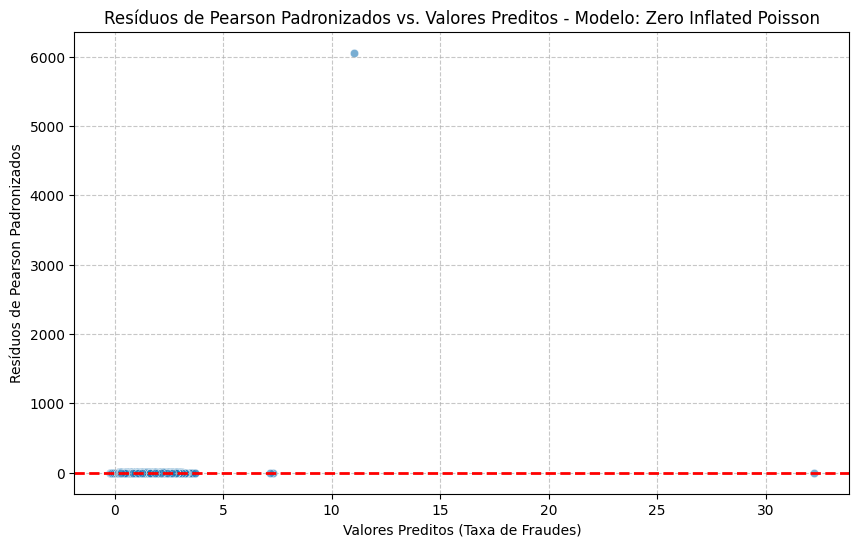

In [223]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson')

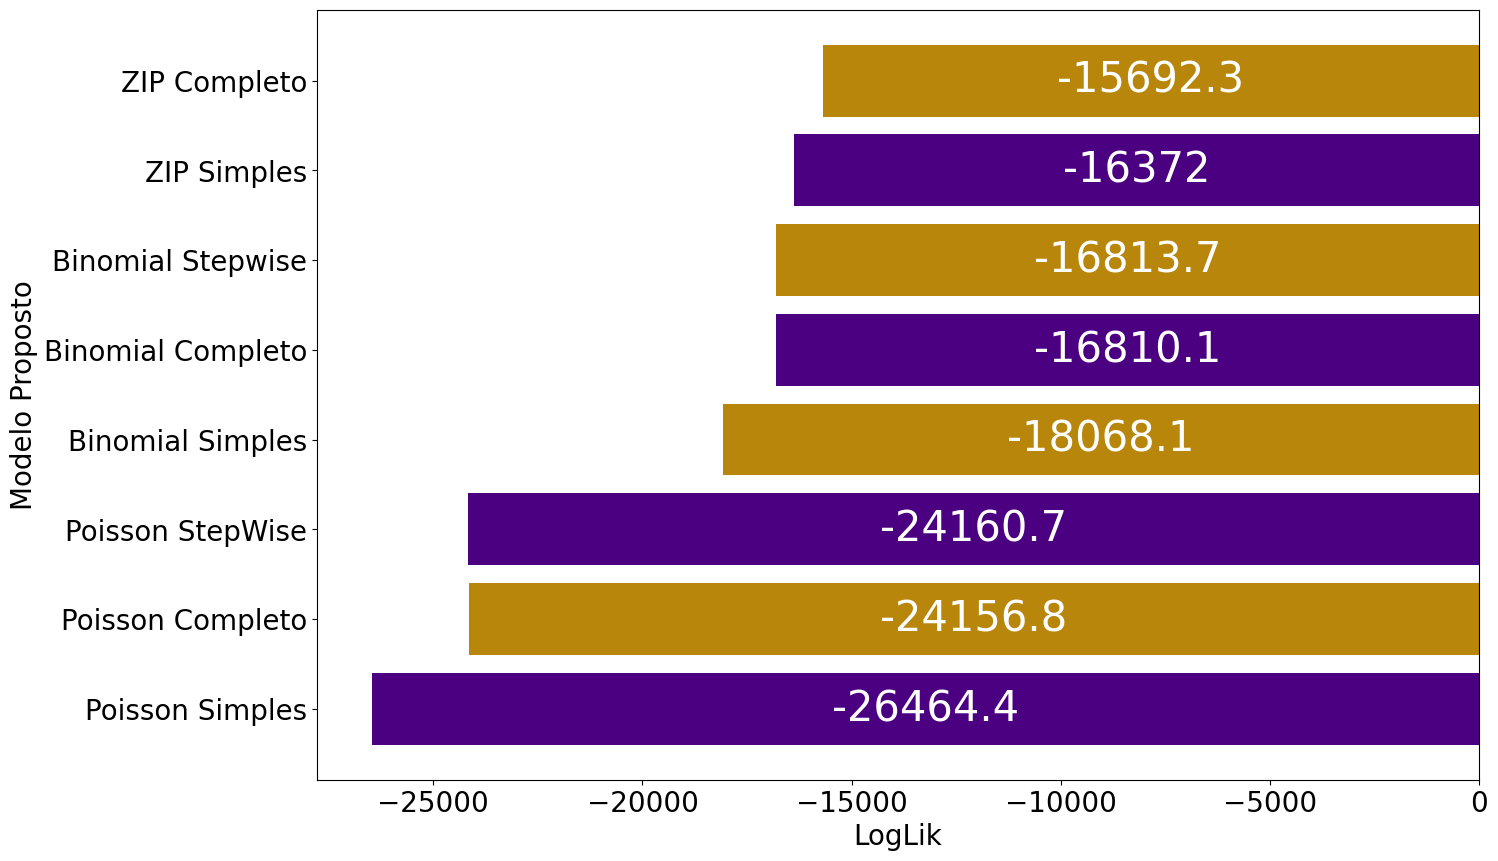

In [224]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [225]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['mean_current_age', 'mean_credit_score', 'mean_num_credit_cards', 'gender_male', 'card_brand_amex', 'card_type_debit_prepaid', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_sports_recreation', 'category_travel_hospitality', 'category_professional_business_services', 'category_construction_contractors', 'category_personal_services']
Exogenas Inflado
['mean_current_age', 'card_type_debit_prepaid', 'category_arts_entertainment_recreation', 'category_sports_recreation', 'category_travel_hospitality', 'category_professional_business_services', 'category_retail_home_garden', 'category_personal_services']


In [226]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_complete_filter = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit(disp=False)
modelo_zip_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14349
Method:                            MLE   Df Model:                           13
Date:                 Fri, 30 May 2025   Pseudo R-squ.:                 0.06127
Time:                         21:04:53   Log-Likelihood:                -15701.
converged:                       False   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.2156      0.023     53.844      0.000       1.171       1.260
inflate_mean_current_age                           -0.1094      0.025     -4.416      0.000      -0.158      -0.061
inflate_card_type_debit_prepaid                    -0.0379      0.024     -1.583      0.113      -0.085       0.009
inflate_category_arts_entertainment_recreation      0.1503      0.030      5.060      0.000       0.092       0.209
inflate_category_sports_recreation                  0.1394      0.026      5.429      0.000       0.089       0.190
inflate_category_travel_hospitality                 0.3010      0.052      5.791      0.000       0.199       0.403
inflate_category_professional_business_services     0.2648      0.027      9.978      0.000       0.213       0.317
inflate_category_retail_home_garden                 0.1352      0.026      5.288      0.000       0.085       0.185
inflate_category_personal_services                 -0.2386      0.023    -10.320      0.000      -0.284      -0.193
const                                               1.0683      0.014     76.352      0.000       1.041       1.096
mean_current_age                                    0.1196      0.015      7.944      0.000       0.090       0.149
mean_credit_score                                   0.0728      0.015      4.985      0.000       0.044       0.101
mean_num_credit_cards                              -0.0375      0.016     -2.301      0.021      -0.070      -0.006
gender_male                                        -0.0297      0.014     -2.171      0.030      -0.057      -0.003
card_brand_amex                                    -0.0959      0.013     -7.282      0.000      -0.122      -0.070
card_type_debit_prepaid                             0.0204      0.013      1.568      0.117      -0.005       0.046
has_chip_no                                         0.0413      0.013      3.250      0.001       0.016       0.066
category_arts_entertainment_recreation             -0.1699      0.019     -9.061      0.000      -0.207      -0.133
category_sports_recreation                         -0.0520      0.014     -3.711      0.000      -0.079      -0.025
category_travel_hospitality                        -0.3226      0.033     -9.898      0.000      -0.386      -0.259
category_professional_business_services            -0.1166      0.014     -8.178      0.000      -0.145      -0.089
category_construction_contractors                  -0.1033      0.043     -2.411      0.016      -0.187      -0.019
category_personal_services                          0.0858      0.012      7.430      0.000       0.063       0.108
===================================================================================================================
"""

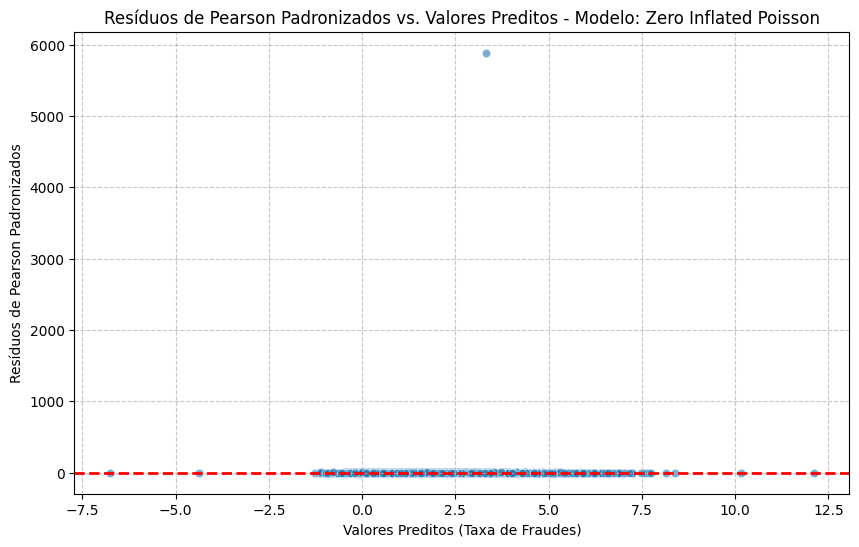

In [227]:
overdisp_plot(modelo_zip_complete_filter, 'Zero Inflated Poisson')

In [228]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZIP', verbose=True, model_params=dict(inflation='logit'), fit_params=dict(disp=False)) #StepwiseZeroInflated(alpha=0.05, model_type='ZIP', verbose=True, model_params=dict(inflation='probit'), fit_params=dict(cov_type='HC0', disp=False))
step_wise.fit_transform(X_scaler, y)

INICIANDO PROCESSO STEPWISE
Modelo: ZIP
Critério de seleção: AIC
Features disponíveis: 21
Dataset: 14363 observações, 11006 zeros (76.6%)
--------------------------------------------------------------------------------
Modelo baseline ajustado:
  - Observações: 14363
  - Zeros: 11006 (76.6%)
  - AIC baseline: 33455.20
  - Convergiu: True
AIC inicial (modelo nulo): 33455.20
--------------------------------------------------------------------------------

ITERAÇÃO 1/100
Processo Forward Selection: Testando features candidatas para inclusão no modelo
Status atual: 0 exógenas, 0 inflacionadas, 0 excluídas

Testando feature: 'mean_current_age'
Critério de significância: p-valor < 0.05
    MOMENTO 1 - Validação inicial de significância
    INICIAL - Todas features significativas (p < 0.05)
    MOMENTO 2 - Pulado (apenas uma feature ou validação desabilitada)
    MOMENTO 3 - Validação final robusta
        Executando validação final robusta
    FINAL - Todas features significativas (p < 0.05)

{'exog': array([[ 0.63169063,  0.139048  ,  0.43378354, ...,  1.91405988,
         -2.37342493, -0.06637782],
        [ 1.49533295, -0.39607073,  0.3963576 , ..., -1.43592392,
         -1.52991768, -0.06637782],
        [ 2.20134978, -1.2282348 ,  0.41578232, ...,  0.23906798,
         -1.52991768, -0.06637782],
        ...,
        [-0.10025542,  0.15719092, -1.02653603, ...,  0.23906798,
         -0.68641042, -0.06637782],
        [ 0.71117826, -0.49124035,  0.19445989, ..., -1.43592392,
          0.15709684, -0.06637782],
        [-1.56547691,  0.63183876, -0.35311397, ...,  0.23906798,
          0.15709684, -0.06637782]]),
 'inf': array([[ 0.139048  ,  0.43378354,  0.88645395, ..., -2.71883724,
          1.63777236,  0.88623415],
        [-0.39607073,  0.3963576 , -0.61574008, ..., -0.61169253,
          0.04825115, -0.45443478],
        [-1.2282348 ,  0.41578232,  0.40206428, ..., -0.61169253,
          0.04825115, -1.12476924],
        ...,
        [ 0.15719092, -1.02653603,  0.1

In [229]:
modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14353
Method:                            MLE   Df Model:                            9
Date:                 Fri, 30 May 2025   Pseudo R-squ.:                 0.01960
Time:                         21:10:02   Log-Likelihood:                -16398.
converged:                        True   LL-Null:                       -16726.
Covariance Type:             nonrobust   LLR p-value:                2.179e-135
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
inflate_const                            1.1307      0.020     56.097      0.000       1.091       1.170
inflate_mean_total_debt                  0.0751      0.023      3.316      0.001       0.031       0.120
inflate_mean_credit_score                0.0475      0.022      2.176      0.030       0.005       0.090
inflate_mean_credit_limit               -0.0508      0.022     -2.265      0.024      -0.095      -0.007
inflate_card_brand_amex                  0.0438      0.021      2.039      0.041       0.002       0.086
inflate_card_brand_discover              0.0788      0.021      3.732      0.000       0.037       0.120
inflate_category_financial_insurance    -0.1071      0.022     -4.877      0.000      -0.150      -0.064
inflate_category_retail_specialty       -0.0540      0.022     -2.456      0.014      -0.097      -0.011
const                                    1.2142      0.011    109.380      0.000       1.192       1.236
mean_current_age                         0.2576      0.015     17.367      0.000       0.229       0.287
mean_total_debt                          0.0505      0.013      3.965      0.000       0.026       0.075
mean_credit_score                        0.1130      0.014      8.134      0.000       0.086       0.140
mean_num_credit_cards                   -0.1434      0.015     -9.410      0.000      -0.173      -0.114
card_brand_amex                         -0.1201      0.013     -9.505      0.000      -0.145      -0.095
card_type_debit_prepaid                  0.0327      0.012      2.762      0.006       0.009       0.056
category_retail_clothing_accessories    -0.0414      0.011     -3.720      0.000      -0.063      -0.020
category_retail_home_garden             -0.0477      0.012     -4.017      0.000      -0.071      -0.024
category_construction_contractors       -0.2378      0.045     -5.316      0.000      -0.326      -0.150
========================================================================================================
"""

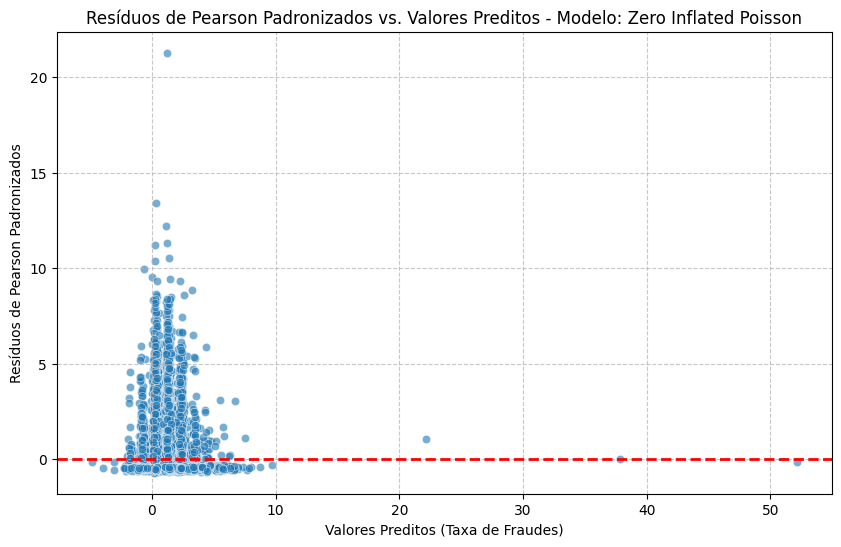

In [230]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [231]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


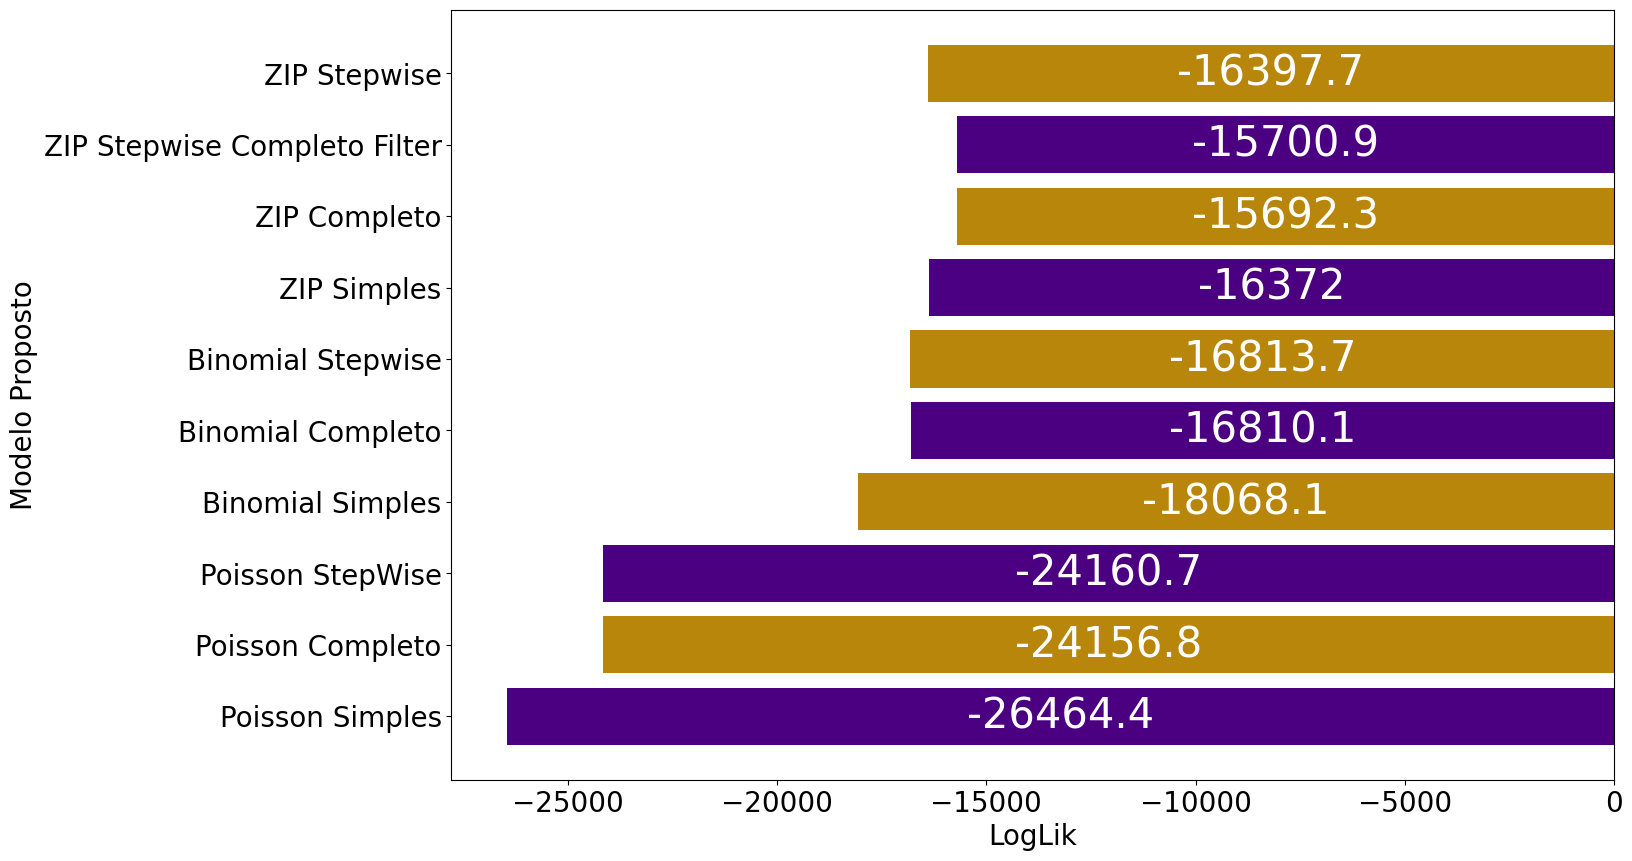

In [232]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise Completo Filter',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [233]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, inflation='logit').fit(disp=False)
  result_tests[column] = modelo_zbneg_test.prsquared

column_max = list(result_tests.keys())[np.argmax(list(result_tests.values()))]
column_max

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'gender_male'

In [234]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [235]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, inflation='logit').fit(disp=False)
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14361
Method:                                      MLE   Df Model:                            1
Date:                           Fri, 30 May 2025   Pseudo R-squ.:                     nan
Time:                                   21:11:04   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                       nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   964.5201        nan        nan        nan         nan         nan
const           594.9903        nan        nan        nan         nan         nan
gender_male      35.1688        nan        nan        nan         nan         nan
alpha         -2583.9604        nan        nan        nan         nan         nan
=================================================================================
"""

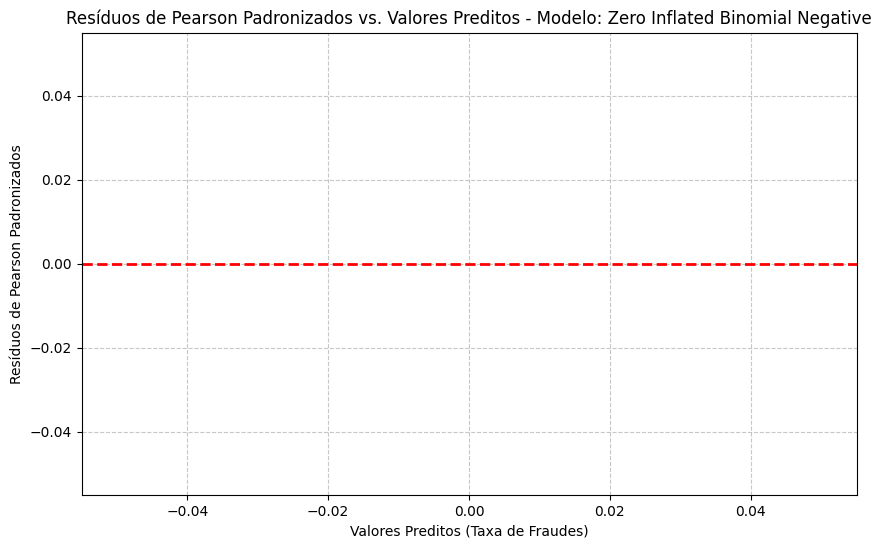

In [236]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [237]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

         Current function value: nan
         Iterations: 1
         Function evaluations: 14
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


In [238]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [239]:
modelo_zinb_complete = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit(disp=False)
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14341
Method:                                      MLE   Df Model:                           21
Date:                           Fri, 30 May 2025   Pseudo R-squ.:                 0.04627
Time:                                   21:11:15   Log-Likelihood:                -14479.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                       nonrobust   LLR p-value:                8.993e-285
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.7562      0.046     16.567      0.000       0.667       0.846
inflate_mean_current_age                           -0.0099      0.041     -0.242      0.809      -0.090       0.070
inflate_mean_total_debt                             0.0519      0.038      1.378      0.168      -0.022       0.126
inflate_mean_credit_score                           0.0907      0.038      2.414      0.016       0.017       0.164
inflate_mean_num_credit_cards                      -0.0833      0.039     -2.110      0.035      -0.161      -0.006
inflate_mean_credit_limit                          -0.0073      0.037     -0.195      0.845      -0.080       0.066
inflate_gender_male                                -0.0515      0.035     -1.453      0.146      -0.121       0.018
inflate_card_brand_amex                            -0.0381      0.033     -1.171      0.242      -0.102       0.026
inflate_card_brand_discover                         0.0069      0.031      0.220      0.826      -0.055       0.069
inflate_card_type_debit_prepaid                    -0.0494      0.036     -1.373      0.170      -0.120       0.021
inflate_has_chip_no                                 0.0306      0.031      0.983      0.326      -0.030       0.092
inflate_category_arts_entertainment_recreation      0.2321      0.046      5.083      0.000       0.143       0.322
inflate_category_health_medical                     0.0203      0.033      0.611      0.541      -0.045       0.085
inflate_category_sports_recreation                  0.1312      0.033      3.947      0.000       0.066       0.196
inflate_category_travel_hospitality                 0.2557      0.068      3.757      0.000       0.122       0.389
inflate_category_retail_clothing_accessories        0.0180      0.029      0.624      0.532      -0.038       0.074
inflate_category_professional_business_services     0.2363      0.035      6.822      0.000       0.168       0.304
inflate_category_financial_insurance               -0.0202      0.033     -0.616      0.538      -0.085       0.044
inflate_category_retail_specialty                   0.0899      0.036      2.502      0.012       0.019       0.160
inflate_category_retail_home_garden                 0.1458      0.033      4.405      0.000       0.081       0.211
inflate_category_construction_contractors           0.0106      0.074      0.143      0.886      -0.134       0.156
inflate_category_personal_services                 -0.2172      0.032     -6.811      0.000      -0.280      -0.155
const                                               0.7248      0.035     20.478      0.000       0.655       0.794
mean_current_age                                    0.2107      0.037      5.639      0.000       0.137       0.284
mean_total

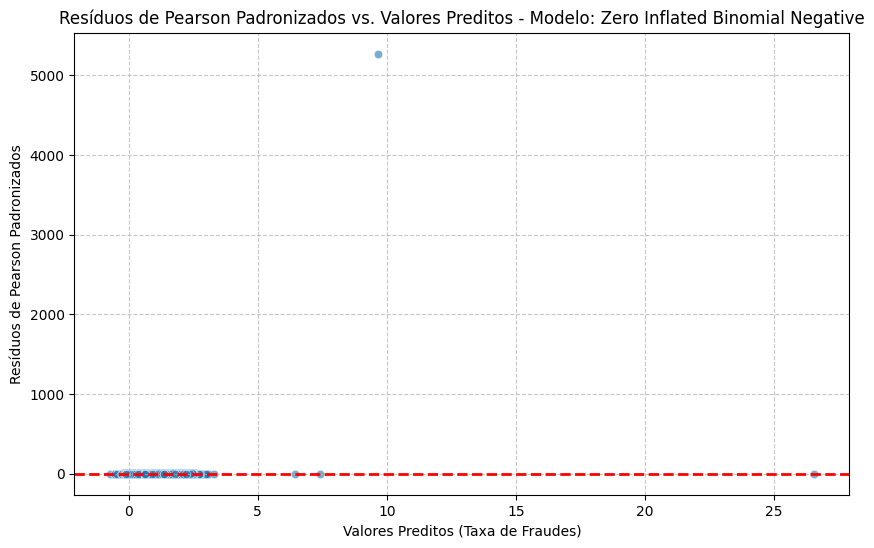

In [240]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Binomial Negative')

In [241]:
df_features_zinp_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['mean_current_age', 'mean_credit_score', 'mean_num_credit_cards', 'card_brand_amex', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_sports_recreation', 'category_travel_hospitality', 'category_professional_business_services', 'category_personal_services']
Exogenas Inflado
['mean_credit_score', 'mean_num_credit_cards', 'category_arts_entertainment_recreation', 'category_sports_recreation', 'category_travel_hospitality', 'category_professional_business_services', 'category_retail_specialty', 'category_retail_home_garden', 'category_personal_services']


In [242]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_complete_filter = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2, inflation='logit').fit(disp=False)
modelo_zinb_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14352
Method:                                      MLE   Df Model:                           10
Date:                           Fri, 30 May 2025   Pseudo R-squ.:                 0.04545
Time:                                   21:11:18   Log-Likelihood:                -14492.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                       nonrobust   LLR p-value:                2.033e-290
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.7641      0.045     17.156      0.000       0.677       0.851
inflate_mean_credit_score                           0.1078      0.034      3.126      0.002       0.040       0.175
inflate_mean_num_credit_cards                      -0.1102      0.034     -3.288      0.001      -0.176      -0.045
inflate_category_arts_entertainment_recreation      0.2160      0.041      5.284      0.000       0.136       0.296
inflate_category_sports_recreation                  0.1259      0.033      3.856      0.000       0.062       0.190
inflate_category_travel_hospitality                 0.2722      0.067      4.068      0.000       0.141       0.403
inflate_category_professional_business_services     0.2158      0.034      6.317      0.000       0.149       0.283
inflate_category_retail_specialty                   0.0715      0.030      2.397      0.017       0.013       0.130
inflate_category_retail_home_garden                 0.1464      0.029      5.034      0.000       0.089       0.203
inflate_category_personal_services                 -0.2331      0.029     -7.919      0.000      -0.291      -0.175
const                                               0.7260      0.034     21.046      0.000       0.658       0.794
mean_current_age                                    0.2295      0.030      7.764      0.000       0.172       0.287
mean_credit_score                                   0.1330      0.033      3.999      0.000       0.068       0.198
mean_num_credit_cards                              -0.1191      0.036     -3.338      0.001      -0.189      -0.049
card_brand_amex                                    -0.1200      0.025     -4.716      0.000      -0.170      -0.070
has_chip_no                                         0.0440      0.026      1.718      0.086      -0.006       0.094
category_arts_entertainment_recreation             -0.1741      0.033     -5.260      0.000      -0.239      -0.109
category_sports_recreation                         -0.0834      0.029     -2.849      0.004      -0.141      -0.026
category_travel_hospitality                        -0.3685      0.059     -6.222      0.000      -0.485      -0.252
category_professional_business_services            -0.1912      0.031     -6.247      0.000      -0.251      -0.131
category_personal_services                          0.1143      0.025      4.633      0.000       0.066       0.163
alpha                                               0.9432      0.069     13.624      0.000       0.807       1.079
===================================================================================================================
"""

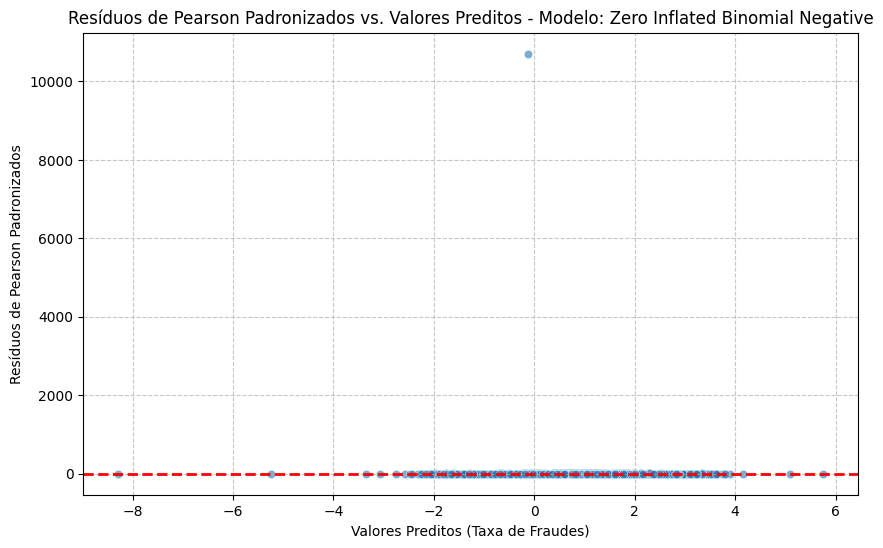

In [243]:
overdisp_plot(modelo_zinb_complete_filter, 'Zero Inflated Binomial Negative')

In [244]:
step_wise = StepwiseZeroInflated(alpha=0.05, model_type='ZINB', verbose=True, selection_criterion='AIC') #, model_params=dict(inflation='probit'), fit_params=dict(cov_type='HC0', disp=False)
step_wise.fit(X_scaler, y)

INICIANDO PROCESSO STEPWISE
Modelo: ZINB
Critério de seleção: AIC
Features disponíveis: 21
Dataset: 14363 observações, 11006 zeros (76.6%)
--------------------------------------------------------------------------------
         Current function value: 1.056997
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
Modelo baseline ajustado:
  - Observações: 14363
  - Zeros: 11006 (76.6%)
  - AIC baseline: 30369.28
  - Convergiu: False
AIC inicial (modelo nulo): 30369.28
--------------------------------------------------------------------------------

ITERAÇÃO 1/100
Processo Forward Selection: Testando features candidatas para inclusão no modelo
Status atual: 0 exógenas, 0 inflacionadas, 0 excluídas

Testando feature: 'mean_current_age'
Critério de significância: p-valor < 0.05
         Current function value: 1.050199
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
    MOMENTO 1 - Validação inicial de sign

StepwiseZeroInflated(fit_params={}, model_params={}, model_type='ZINB',
                     verbose=True)

In [245]:
modelo_zinb_stepwise = step_wise.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14362
Method:                                      MLE   Df Model:                            0
Date:                           Fri, 30 May 2025   Pseudo R-squ.:              -3.339e-10
Time:                                   21:12:31   Log-Likelihood:                -15182.
converged:                                 False   LL-Null:                       -15182.
Covariance Type:                       nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.6463      0.049     13.205      0.000       0.550       0.742
const             0.9557      0.035     27.156      0.000       0.887       1.025
alpha             1.2940      0.101     12.847      0.000       1.097       1.491
=================================================================================
"""

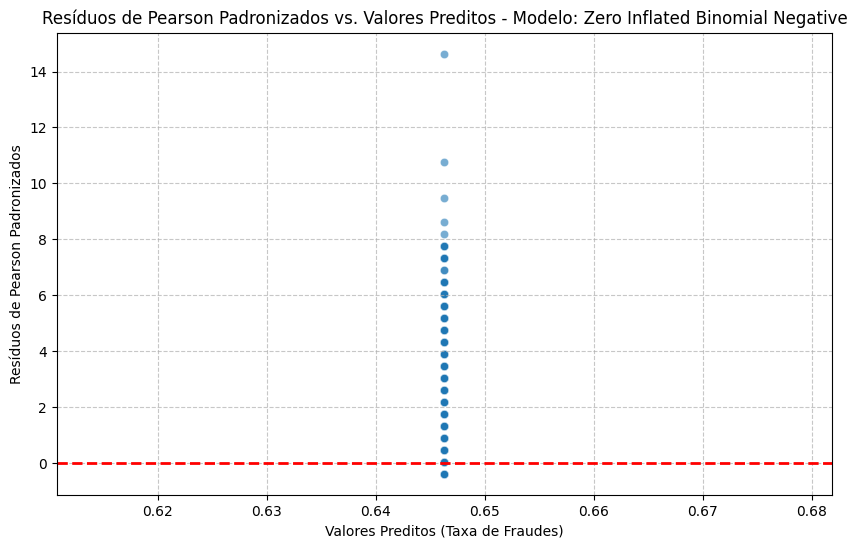

In [246]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

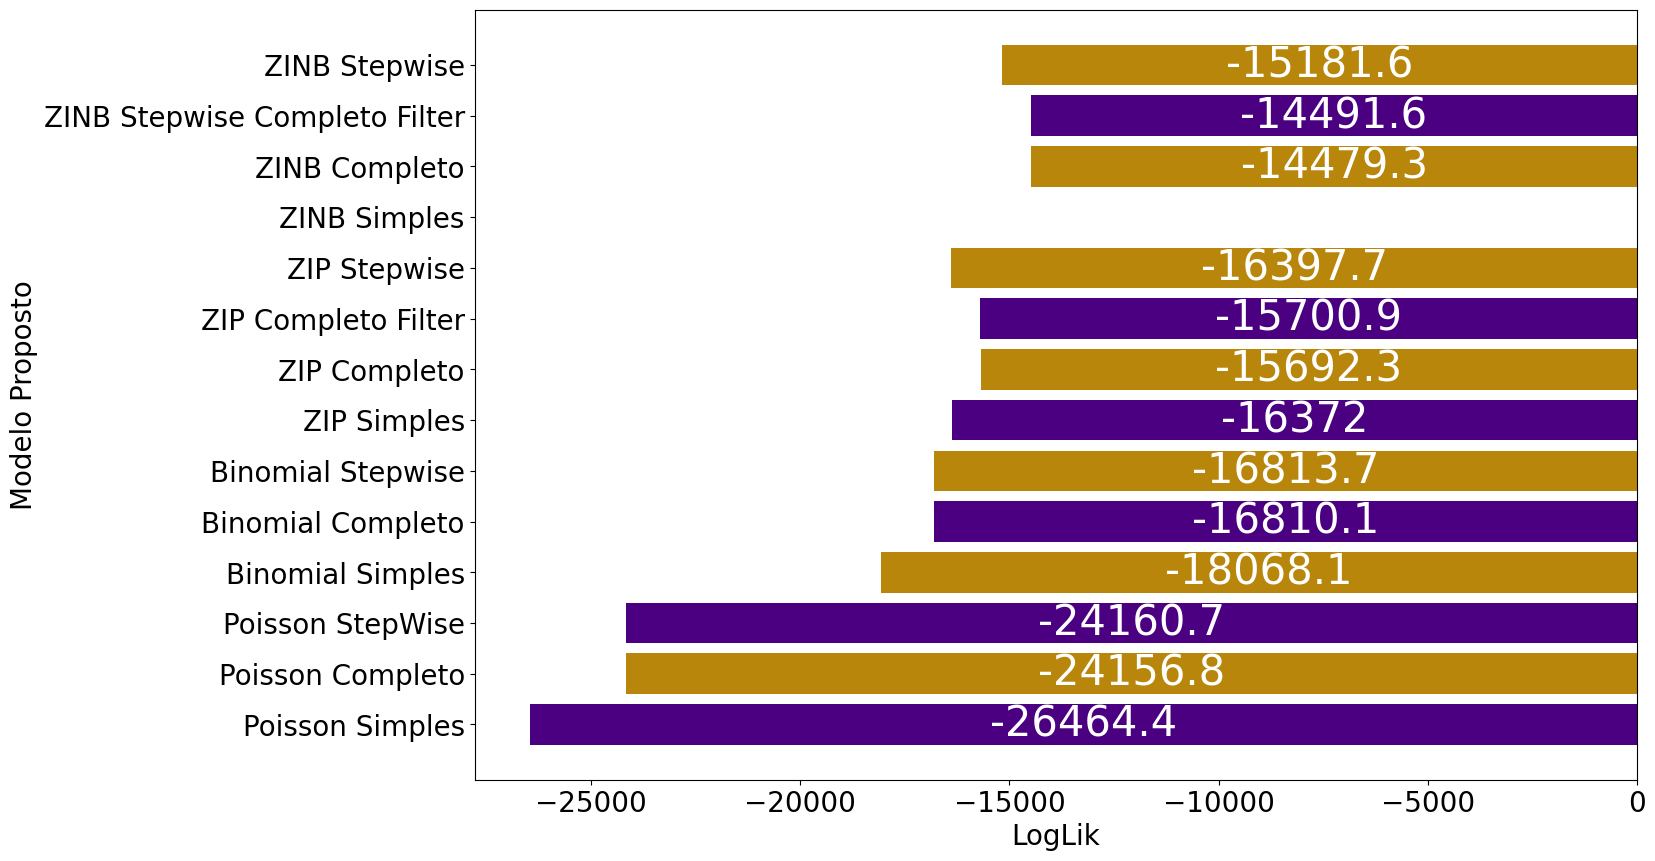

In [247]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Completo Filter',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise Completo Filter',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_complete_filter.llf,
        modelo_zinb_stepwise.llf
      ]
})

In [248]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Completo Filter',
  'ZIP Stepwise',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Completo Filter',
  'ZIMB Stepwise',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_complete_filter,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_complete_filter,
    modelo_zinb_stepwise
]

In [264]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

In [265]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='AIC')

,title,LLF,BIC,AIC,PseudoR2
11,ZIMB Completo Filter,-14491.627543,29193.848122,29027.255086,4.545059e-02
10,ZIMB Completo,-14479.261343,29389.281169,29048.522686,4.626514e-02
12,ZIMB Stepwise,-15181.642171,30392.001575,30369.284343,-3.338627e-10
8,ZIP Completo Filter,-15700.865627,31621.896700,31447.731253,6.126746e-02
7,ZIP Completo,-15692.299491,31805.785054,31472.598982,6.177961e-02
6,ZIP Simples,-16371.981131,32782.251904,32751.962261,2.114241e-02
9,ZIP Stepwise,-16397.699230,32967.701853,32831.398460,1.960476e-02
5,Binomial Stepwise,-16813.685615,-118481.892869,33663.371229,2.429548e-01
4,Binomial Completo,-16810.116735,-118412.453571,33672.233470,2.433311e-01
3,Binomial Simples,-18068.145226,-116168.416291,36140.290452,9.871283e-02


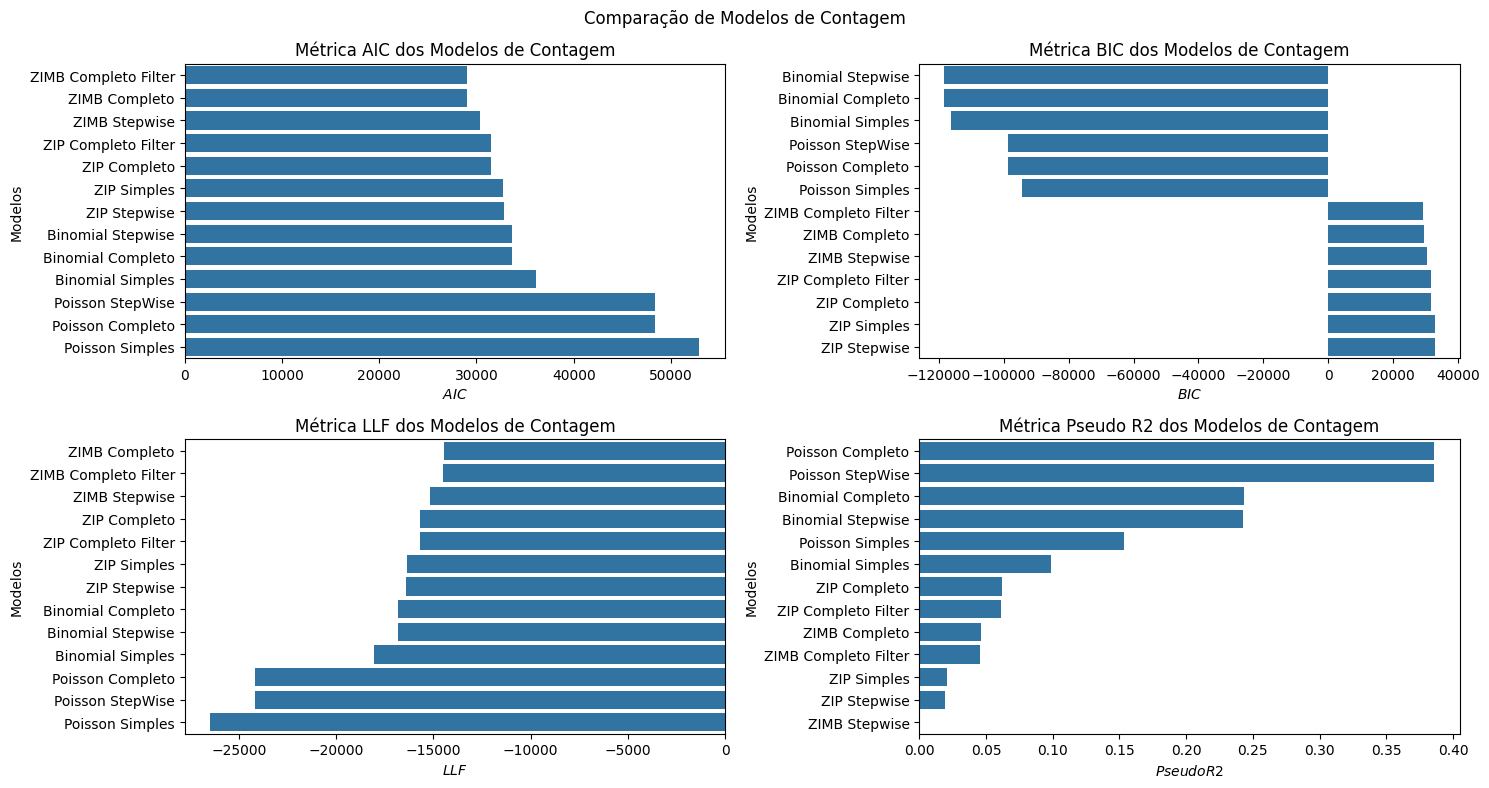

In [266]:
plt.figure(figsize=(15,8))
plt.suptitle('Comparação de Modelos de Contagem')

plt.subplot(2,2,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(by=['AIC', 'title'], ascending=True), y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['BIC', 'title'], ascending=True), y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['LLF', 'title'], ascending=False), y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.subplot(2,2,4)
plt.title('Métrica Pseudo R2 dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['PseudoR2', 'title'], ascending=False), y='title', x='PseudoR2')
plt.xlabel('$Pseudo R2$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()

In [267]:
metrics_titles = []
metrics_mse = []
metrics_rmse = []

In [268]:
for title, model in zip(titles, models):

    if np.isnan(model.llf):
      continue

    metrics_titles.append(title)
    metrics_mse.append(mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))
    metrics_rmse.append(root_mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))

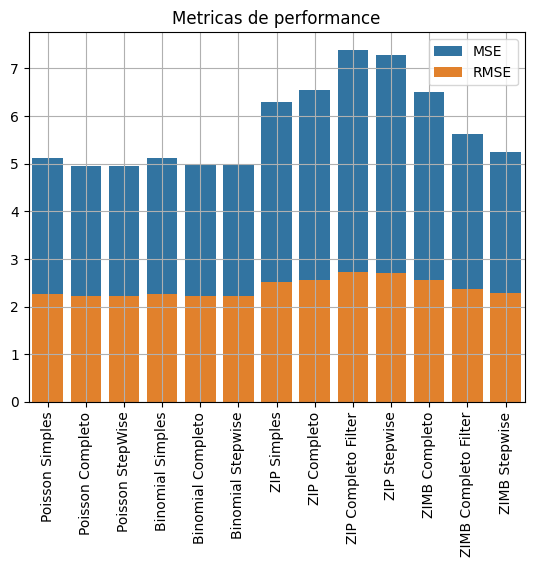

In [269]:
plt.title('Metricas de performance')
sns.barplot(x=metrics_titles, y=metrics_mse, label='MSE')
sns.barplot(x=metrics_titles, y=metrics_rmse, label='RMSE')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [270]:
df_predict_models = pd.concat([model.fittedvalues for model in models], axis=1)
df_predict_models.columns = titles

for column in df_predict_models.columns:
  df_predict_models[column] = df_predict_models[column].apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

df_predict_models['Target'] = y
df_predict_models.head()

,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise,Target
0,0,0,0,0,0,0,2,2,5,0,844,1,0,1,0
1,1,1,1,1,1,1,1,1,3,0,844,0,0,1,0
2,0,1,1,0,1,1,2,1,2,0,1261,1,0,1,0
3,1,0,0,1,0,0,1,2,3,0,635,1,1,1,1
4,1,0,0,1,0,0,1,2,5,4,2305,2,0,1,0


In [271]:
df_resume = df_predict_models['Target'].value_counts().reset_index()
df_resume.columns = ['Target', 'Quantidade']
df_resume = df_resume.sort_values(by='Target').reset_index(drop=True)
df_resume.head()

,Target,Quantidade
0,0,11006
1,1,975
2,2,646
3,3,393
4,4,304


In [272]:
resumes = [df_resume]
for column in titles:
  df_resume = df_predict_models.assign(ok=lambda x: x['Target'] == x[column]).groupby('Target').agg({'ok':'sum'}).reset_index()
  df_resume.columns = ['Target', column]
  df_resume.drop(columns='Target', inplace=True)
  resumes.append(df_resume)
df_resume = pd.concat(resumes, axis=1)

In [273]:
df_resume

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,11006,3511,4942,4943,3511,5104,5107,0,888,3245,4004,524,3931,4101,0
1,1,975,752,451,449,752,427,428,752,610,356,340,0,427,493,975
2,2,646,0,178,177,0,173,173,113,104,125,93,0,33,163,0
3,3,393,0,9,10,0,11,11,0,3,20,13,0,0,7,0
4,4,304,0,0,0,0,1,1,0,0,3,4,0,0,0,0
5,5,257,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,6,177,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,88,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [274]:
df_resume_percent = df_resume.copy()
for column in titles:
  df_resume_percent[column] = round(df_resume_percent[column] / df_resume_percent['Quantidade'], 2)
df_resume_percent

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,11006,0.32,0.45,0.45,0.32,0.46,0.46,0.00,0.08,0.29,0.36,0.05,0.36,0.37,0.0
1,1,975,0.77,0.46,0.46,0.77,0.44,0.44,0.77,0.63,0.37,0.35,0.00,0.44,0.51,1.0
2,2,646,0.00,0.28,0.27,0.00,0.27,0.27,0.17,0.16,0.19,0.14,0.00,0.05,0.25,0.0
3,3,393,0.00,0.02,0.03,0.00,0.03,0.03,0.00,0.01,0.05,0.03,0.00,0.00,0.02,0.0
4,4,304,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.0
5,5,257,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
6,6,177,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
7,7,163,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
8,8,111,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
9,9,88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0


In [275]:
df_resume_percent[titles].apply(lambda x: (len([xi for xi in x if xi > 0])/len(x)) * x.sum(), axis=0).sort_values(ascending=False)

,0
Poisson Completo,0.1936
Poisson StepWise,0.1936
Binomial Stepwise,0.1920
Binomial Completo,0.1920
ZIMB Completo Filter,0.1840
ZIP Completo Filter,0.1820
ZIP Stepwise,0.1780
ZIP Completo,0.1408
ZIMB Completo,0.1020
Poisson Simples,0.0872
